# Cluster Analysis for Metal Nanoparticle Surface Atoms Clustering

This jupyter notebook is used to perform clustering on tabular data consisting of various geometrical features of (multi)metallic nanoparticles.

TO DO:
- Replace simple for loops with map() functions to speed up 

## Index:

- [Requirements](#requirements)
- [Import Libraries](#import-libraries)
- [Load Data](#load-data)
- [ILS Clustering](#ils-clustering)
- [Cluster Evaluation](#cluster-eval)
- [Cluster Analysis Pipeline](#cluster-analysis)
- [Cluster Visualisation](#cluster-vis)
- [Clustering Results](#cluster-results)
    - [Cuboctahedron Small 0 K](#COS1T000)
    - [Icosahedron Small 0 K](#ICS1T000)
    - [Truncated Octahedron Small 0 K](#TOS1T000)
    - [Cube Small 0 K](#CUS1T000)
    - [Cube Medium 0 K](#CUS2T000)
    - [Cube Large 0 K](#CUS3T000)
    - [Decahedron Small 0 K](#DHS1T000)
    - [Decahedron Medium 0 K](#DHS2T000)
    - [Decahedron Large 0 K](#DHS3T000)
    - [Octahedron Small 0 K](#OTS1T000)
    - [Octahedron Medium 0 K](#OTS2T000)
    - [Octahedron Large 0 K](#OTS3T000)
    - [Rhombic Dodecahedron Small 0 K](#RDS1T000)
    - [Rhombic Dodecahedron Medium 0 K](#RDS2T000)
    - [Rhombic Dodecahedron Large 0 K](#RDS3T000)
    - [Tetrahedron Small 0 K](#THS1T000)
    - [Tetrahedron Medium 0 K](#THS2T000)
    - [Tetrahedron Large 0 K](#THS3T000)
    - [Octahedron Small 323 K](#OTS1T323)
    - [Octahedron Medium 323 K](#OTS2T323)
    - [Octahedron Large 323 K](#OTS3T323)
    - [Rhombic Dodecahedron Small 323 K](#RDS1T323)
    - [Rhombic Dodecahedron Medium 323 K](#RDS2T323)
    - [Rhombic Dodecahedron Large 323 K](#RDS3T323)
    - [Tetrahedron Small 323 K](#THS1T323)
    - [Tetrahedron Medium 323 K](#THS2T323)
    - [Tetrahedron Large 323 K](#THS3T323)
    - [Octahedron Small 523 K](#OTS1T523)
    - [Octahedron Medium 523 K](#OTS2T523)
    - [Octahedron Large 523 K](#OTS3T523)
    - [Rhombic Dodecahedron Small 523 K](#RDS1T523)
    - [Rhombic Dodecahedron Medium 523 K](#RDS2T523)
    - [Rhombic Dodecahedron Large 523 K](#RDS3T523)
    - [Tetrahedron Small 523 K](#THS1T523)
    - [Tetrahedron Medium 523 K](#THS2T523)
    - [Tetrahedron Large 523 K](#THS3T523)
    - [Disordered Pd 1](#disPd1)
    - [Disordered Pd 2](#disPd2)
    - [Disordered Pd 3](#disPd3)

<a id='requirements'></a>
## Requirements

The following files should be available in a specified directory (./data/ here):
* "dfAlls.pickle"
* "dfNoLVHCs.pickle"
* "dfScaledNoLVHCs.pickle"

<a id='import-libraries'></a>
## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# %%capture
import os
import random
import time
import sys
import warnings
from copy import deepcopy

import math
from math import sqrt, sin
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams
# from matplotlib.colors import ListedColormap
import numpy as np
# import modin.pandas as modpd
import pandas as pd
import pickle
import plotly.express as px
from scipy.stats import iqr, skew
import seaborn as sns
import sklearn

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, MeanShift, SpectralClustering
# from clustergram import Clustergram
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from tsfresh.feature_extraction import feature_calculators
import ils.dirichletMixtures as dm
import ils.agglomerativeClustering as hc
import ils.utils as ut
import ils.cfsdp as cfs
from ils.basic_ils import ILS

# Visualisation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Miscellaneous
from ash.ash import ash
from itertools import combinations
from KDEpy import NaiveKDE, FFTKDE
from scipy.integrate import romb, simps, trapezoid
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import find_peaks_cwt
from scipy.special import rel_entr

In [3]:
# Set up notebook environment
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
FIG_SIZE, DPI, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# rcParams['figure.figsize'] = [8, 5]
# rcParams['figure.autolayout'] = True
# rcParams['font.style'] = 'normal'
# rcParams['xtick.labelsize'] = 10
# rcParams['ytick.labelsize'] = 10

# np.set_printoptions(precision=4, suppress=True)

In [4]:
# Print version for reproducibility
print(f"numpy version {np.__version__}")
print(f"pandas version {pd.__version__}")
print(f"seaborn version {sns.__version__}")
print(f"sklearn version {sklearn.__version__}")

numpy version 1.21.5
pandas version 1.3.5
seaborn version 0.11.2
sklearn version 1.0.2


<a id='load-data'></a>
## Load Data

In [9]:
%store -r testCases 
featDirPath = 'data/NCPacFeats'
with open('data/dfAlls.pickle', 'rb') as f: 
    dfAlls = pickle.load(f)
with open('data/dfNoLVHCs.pickle', 'rb') as f: 
    dfNoLVHCs = pickle.load(f)
with open('data/dfScaledNoLVHCs.pickle', 'rb') as f: 
    dfScaledNoLVHCs = pickle.load(f)
    
varThreshIdx, corrThreshIdx = 0, 0  # Data retaining features with variance > 0.0 and correlation < 0.9 with another feature
dfNoLVHCs, dfScaledNoLVHCs = dfNoLVHCs[varThreshIdx][corrThreshIdx], dfScaledNoLVHCs[varThreshIdx][corrThreshIdx]
# for (i, dfScaledNoLVHC) in enumerate(dfScaledNoLVHCs): 
#     display(dfScaledNoLVHC.sample(5))

In [10]:
# Features that do not satisfy rotational invariance are excluded
spaceList = ['x', 'y', 'z']
blList = ['blavg', 'blmax', 'blmin', 'blnum']
ba1List = ['ba1avg', 'ba1max', 'ba1min', 'ba1num']
ba2List = ['ba2avg', 'ba2max', 'ba2min', 'ba2num']
btList = ['btposavg', 'btposmax', 'btposmin', 'btposnum', 
          'btnegavg', 'btnegmax', 'btnegmin', 'btnegnum']
radList = ['rad']
neighList = ['cn', 'gcn', 'scn', 'q6q6']  # "sgcn"
orderList = ['centParam', 'entroParam', 'entroAvgParam']  # "angParam", "Ixx", "Iyy", "Izz", "degenDeg"
chiList = ['chi2', 'chi3', 'chi4', 'chi5', 'chi6', 'chi7', 'chi8', 'chi9']  # "chi1"
qList = ['q2', 'q4', 'q6', 'q8', 'q10', 'q12', 
         'q2avg', 'q4avg', 'q6avg', 'q8avg', 'q10avg', 'q12avg']
disorderList = ['disord2', 'disord4', 'disord6', 'disord8', 'disord10', 'disord12', 
                'disordAvg4', 'disordAvg2', 'disordAvg6', 'disordAvg8', 'disordAvg10', 'disordAvg12']  # All of them do not satisfy the invariance

posList = spaceList + radList
geomList = blList + ba1List + ba2List + btList + chiList
steinList = qList  # + disorderList

# Generate combinations of features for game theoretical approach
allFeat = [tuple(posList), tuple(geomList), tuple(neighList), tuple(orderList), tuple(steinList)]
combList = []
for i in range(len(allFeat), 0, -1):
    combObj = combinations(allFeat, i)
    for (j, comb) in enumerate(combObj):
        cList = []
        for tup in comb: cList += list(tup)
        combList.append(cList)
for (i, comb) in enumerate(combList): 
    print(f"Combination {i}: {comb}")
print(f"Total number of combinations: {len(combList)}")
%store combList
%store -r PCAcomboResDicts
# PCAcomboResDicts = [None] * len(testCases)

Combination 0: ['x', 'y', 'z', 'rad', 'blavg', 'blmax', 'blmin', 'blnum', 'ba1avg', 'ba1max', 'ba1min', 'ba1num', 'ba2avg', 'ba2max', 'ba2min', 'ba2num', 'btposavg', 'btposmax', 'btposmin', 'btposnum', 'btnegavg', 'btnegmax', 'btnegmin', 'btnegnum', 'chi2', 'chi3', 'chi4', 'chi5', 'chi6', 'chi7', 'chi8', 'chi9', 'cn', 'gcn', 'scn', 'q6q6', 'centParam', 'entroParam', 'entroAvgParam', 'q2', 'q4', 'q6', 'q8', 'q10', 'q12', 'q2avg', 'q4avg', 'q6avg', 'q8avg', 'q10avg', 'q12avg']
Combination 1: ['x', 'y', 'z', 'rad', 'blavg', 'blmax', 'blmin', 'blnum', 'ba1avg', 'ba1max', 'ba1min', 'ba1num', 'ba2avg', 'ba2max', 'ba2min', 'ba2num', 'btposavg', 'btposmax', 'btposmin', 'btposnum', 'btnegavg', 'btnegmax', 'btnegmin', 'btnegnum', 'chi2', 'chi3', 'chi4', 'chi5', 'chi6', 'chi7', 'chi8', 'chi9', 'cn', 'gcn', 'scn', 'q6q6', 'centParam', 'entroParam', 'entroAvgParam']
Combination 2: ['x', 'y', 'z', 'rad', 'blavg', 'blmax', 'blmin', 'blnum', 'ba1avg', 'ba1max', 'ba1min', 'ba1num', 'ba2avg', 'ba2max', 

In [12]:
# Define global variables and hyperparameters
RANDOM_SEED = 42  # Random seed
VERBOSE = True  # Boolean determining whether print statements are activated in most functions
SHOW_IMG = True  # Boolean determining whether plots are shown in most functions
NON_POS_PEAK_FUNC_MEAN_THRESH = -0.02  # mean threshold in findPeaks()
NON_POS_PEAK_FUNC_STD_THRESH = 0.02  # standard deviation threshold in findPeaks()
SIG_CONST_SCALER = 20  # Scaler for SIG_CONST in findPeaks()
PEAK_FUNC = 'S2'  # Peak function for peak finding algorithm in locateDensestIdx()
DIFF_THRESH = 0.01  # Threshold that specifies if 2 peaks are different enough in the case of ordered nanoparticles in locateDensestIdx()
HIST_BIN_CHOICE = 3  # Choice of method to calculate number of bins or binwidth for GCN histograms in plotGCN(), currently 'doane'
WINDOW_SIZE = 50  # Window size for peak finding algorithm in runClustering()
SIG_CONST = 1.2  # Significance constant for peak finding algorithm in runClustering()
MIN_CLUST_SIZE = 10  # Minimum cluster size for clustering in runClustering()
SURF_ATOM_BUFFER_PERC = 10  # Constant for calculating the buffer range of number of surface atoms in gameCase()
REACTION_POTENTIAL_DISTRIBUTION_TARGET_TOTAL_AREA = 1.0  # Targeted total area under the reference reaction potential distribution curve in potFromGCN() 
REACTION_POTENTIAL_DISTRIBUTION_AREA_ERROR_THRESH = 0.001  # Error threshold for adjustment of area under the reference reaction potential distribution curve in potFromGCN() 
GCN_INTERVAL = 0.001  #  Intervals for generation of a global sequence of GCN values
GCN_LOW_BOUND, GCN_HIGH_BOUND = 1.0, 14.0  # Lower and upper bounds for generation of global sequence of GCN values
# Added GCN_INTERVAL below because ndarray from np.arange() is open ended on right hand, NOTE: be careful to avoid evaluation point out-of-bound error for FFTKDE()
GCN_XRANGE = np.arange(start=GCN_LOW_BOUND, stop=GCN_HIGH_BOUND+GCN_INTERVAL, step=GCN_INTERVAL)  # Sequence of GCN values used to obtain corresponding potential values
PCA_EXP_VAR_THRESHOLD = 0.99  # Threshold for targetted explained variance to decide the number of principal components used for transformation
cmap = 'jet'
attDict = {"x": {"name": "x", "leg": []}, 
           "y": {"name": "y", "leg": []}, 
           "z": {"name": "z", "leg": []}, 
           "blavg": {"name": "Average Bond Length", "leg": []}, 
           "blmax": {"name": "Maximum Bond Length", "leg": []}, 
           "blmin": {"name": "Minimum Bond Length", "leg": []}, 
           "blnum": {"name": "Number of Bonds", "leg": []}, 
           "ba1avg": {"name": "Average First Order Bond Angle", "leg": []}, 
           "ba1max": {"name": "Maximum First Order Bond Angle", "leg": []}, 
           "ba1min": {"name": "Minimum First Order Bond Angle", "leg": []}, 
           "ba1num": {"name": "Number of First Order Bond Angles", "leg": []}, 
           "ba2avg": {"name": "Average Second Order Bond Angle", "leg": []}, 
           "ba2max": {"name": "Maximum Second Order Bond Angle", "leg": []}, 
           "ba2min": {"name": "Minimum Second Order Bond Angle", "leg": []}, 
           "ba2num": {"name": "Number of Second Order Bond Angles", "leg": []}, 
           "btposavg": {"name": "Average Positive Bond Torsion", "leg": []}, 
           "btposmax": {"name": "Maximum Positive Bond Torsion", "leg": []}, 
           "btposmin": {"name": "Minimum Positive Bond Torsion", "leg": []}, 
           "btposnum": {"name": "Number of Positive Bond Torsions", "leg": []}, 
           "btnegavg": {"name": "Average Negative Bond Torsion", "leg": []}, 
           "btnegmax": {"name": "Maximum Negative Bond Torsion", "leg": []}, 
           "btnegmin": {"name": "Minimum Negative Bond Torsion", "leg": []}, 
           "btnegnum": {"name": "Number of Negative Bond Torsions", "leg": []}, 
           "cn": {"name": "Coordination Number", "leg": []}, 
           "gcn": {"name": "Generalised Coordination Number", "leg": []}, 
           "scn": {"name": "Surface Coordination Number", "leg": []}, 
           "sgcn": {"name": "Surface Generalised Coordination Number", "leg": []}, 
           "rad": {"name": "Radial Distance", "leg": []}, 
           "q6q6": {"name": "Number of Q6Q6 Neighbours", "leg": []}, 
           "angParam": {"name": "Angular Parameter", "leg": []}, 
           "centParam": {"name": "Centrosymmetry Parameter", "leg": []}, 
           "entroParam": {"name": "Entropy Parameter", "leg": []}, 
           "entroAvgParam": {"name": "Average Entropy Parameter", "leg": []},
           "chi1": {"name": "Chi Parameters 1", "leg": []}, 
           "chi2": {"name": "Chi Parameters 2", "leg": []}, 
           "chi3": {"name": "Chi Parameters 3", "leg": []}, 
           "chi4": {"name": "Chi Parameters 4", "leg": []},
           "chi5": {"name": "Chi Parameters 5", "leg": []}, 
           "chi6": {"name": "Chi Parameters 6", "leg": []}, 
           "chi7": {"name": "Chi Parameters 7", "leg": []},
           "chi8": {"name": "Chi Parameters 8", "leg": []}, 
           "chi9": {"name": "Chi Parameters 9", "leg": []}, 
           "q2": {"name": "Q2 Values", "leg": []}, 
           "q4": {"name": "Q4 Values", "leg": []}, 
           "q6": {"name": "Q6 Values", "leg": []}, 
           "q8": {"name": "Q8 Values", "leg": []},
           "q10": {"name": "Q10 Values", "leg": []}, 
           "q12": {"name": "Q12 Values", "leg": []}, 
           "q2avg": {"name": "Averaged Q2 Values", "leg": []}, 
           "q4avg": {"name": "Averaged Q4 Values", "leg": []}, 
           "q6avg": {"name": "Averaged Q6 Values", "leg": []}, 
           "q8avg": {"name": "Averaged Q8 Values", "leg": []},
           "q10avg": {"name": "Averaged Q10 Values", "leg": []}, 
           "q12avg": {"name": "Averaged Q12 Values", "leg": []}, 
           "disord2": {"name": "Q2 Disorder Parameter", "leg": []}, 
           "disord4": {"name": "Q4 Disorder Parameter", "leg": []}, 
           "disord6": {"name": "Q6 Disorder Parameter", "leg": []}, 
           "disord8": {"name": "Q8 Disorder Parameter", "leg": []}, 
           "disord10": {"name": "Q10 Disorder Parameter", "leg": []}, 
           "disord12": {"name": "Q12 Disorder Parameter", "leg": []}, 
           "disordAvg2": {"name": "Q2 Average Disorder Parameter", "leg": []}, 
           "disordAvg4": {"name": "Q4 Average Disorder Parameter", "leg": []}, 
           "disordAvg6": {"name": "Q6 Average Disorder Parameter", "leg": []}, 
           "disordAvg8": {"name": "Q8 Average Disorder Parameter", "leg": []}, 
           "disordAvg10": {"name": "Q10 Average Disorder Parameter", "leg": []}, 
           "disordAvg12": {"name": "Q12 Average Disorder Parameter", "leg": []}, 
           "Ixx": {"name": "Moment of Inertia X Direction", "leg": []}, 
           "Iyy": {"name": "Moment of Inertia Y Direction", "leg": []}, 
           "Izz": {"name": "Moment of Inertia Z Direction", "leg": []}, 
           "degenDeg": {"name": "Degeneracy Degree", "leg": []}, 
           "surf": {"name": "Surface", "leg": []}, 
           "order": {"name": "Order", "leg": []}, 
           "ILSclustAll": {"name": "ILS All Cluster Label", "leg": []}, 
           "ILSclustSurf": {"name": "ILS Surface Cluster Label", "leg": []}}

<a id='ils-clustering'></a>
## ILS Clustering

In [13]:
def calcRhoDeltaGamma(X, verbose=False):
    """
    Returns rho (density), delta (min distance from points with higher rho), gamma (scores) for 
    Clustering by Fast Search and Finding of Density Peaks (CFSDP) (adapted from Thea Hsu's codes).
    
    Inputs:
        X : DataFrame with each column being a feature and each row being an atom instance
        verbose : Boolean determining whether print statements are activated
    Outputs:
        density : NumPy matrix representing density of N points (rho)
        neighDensPoints : NumPy matrix representing computing the minimum distance between the point and any other with high density (delta)
        scores : NumPy matrix representing product of rho and delta (gamma)
    """
    
    # Choose cutoff distance for computation of rho and delta non-parametrically
    distanceMatrix = pairwise_distances(X)
    dc, dcValueList, field = cfs.choose_dc(distanceMatrix)
    if verbose: 
        print(f"    Cutoff distance to compute ρ and δ: {dc:.3f}")  
    
    if verbose: 
        print("    Computing ρ, δ, and γ...")
    density = cfs.continuous_density(distanceMatrix, dc)  # rho
    neighDensPoints = cfs.delta_function(distanceMatrix, density)  # delta
    scores = cfs.choosing_centernumber(density, neighDensPoints)  # gamma
    
    return density, neighDensPoints, scores

In [14]:
def initILS(X, caseID, combID, initL, attList=['order', 'surf', 'cn'], allOrSurf='Surface', figSize=(16, 5), verbose=False):
    """
    Initialise a point at 'initL', run ILS over atoms specified by 'allOrSurf', and colour the plot by 
    attributes listed in 'attList'.
    
    Inputs:
        X : DataFrame with each column being a feature and each row being an atom instance
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        initL : (List of) initial label for ILS (correspond to index of X instead of row number)
        attList : List of features present in the targeted DataFrame to colour the ILS plots with
        allOrSurf : String indicating the portion of atoms of interest {'All', 'Surface'}
        verbose : Boolean determining whether print statements are activated
    Outputs:
        newL : Series of the labels of each sample; ordered by the labelling order
        orderedL : DataFrame (ordered by the labelling order) containing 
                    minR : Float representing high-dimensional distance from the previous nearest labelled neighbour (label source)
                    IDclosestLabel : Float representing the cluster label of the previous nearest labelled neighbour (label source)
                    order : Integer representing the labelling order of each sample
    """
    if verbose: print(f"  Running ILS on {allOrSurf} atoms, initial labelled index: {initL}")
    X = X.copy()
    XnoScale = dfNoLVHCs[caseID][dfNoLVHCs[caseID]["surf"] == 1] if allOrSurf == "Surface" else dfNoLVHCs[caseID]
    attLists = [tuple(attList[i:i+3]) for i in range(0, len(attList), 3)]  # In case there are more than 3 attributes

    # Initialise a label
    X['label'] = 0
    X.loc[initL, 'label'] = 1
    X.index.name = 'ID'
    newL, orderedL = ILS(X, 'label')
    orderedL['order'] = range(len(orderedL))
    
    for (i, atts) in enumerate(attLists):
        print()
        fig, axs = plt.subplots(1, len(attList), figsize=figSize);
        for (j, ax) in enumerate(axs):
            colorList = range(len(orderedL)) if atts[j] == 'order' else XnoScale[atts[j]][list(orderedL.index)]
            ax.plot(orderedL['order'], orderedL['minR'], color='k', marker=None, linestyle='solid', linewidth=0.3, zorder=1);
            scatter = ax.scatter(orderedL["order"], orderedL["minR"], c=colorList, cmap=cmap, s=24, zorder=2);
            # sns.scatterplot(data=orderedL, x='order', y='minR', hue='order', palette='flare', legend=False);
            if atts[j] == 'surf':
                ax.legend(handles=scatter.legend_elements()[0], labels=('Bulk', 'Surf'));  # title='Surface'
            elif atts[j] == 'cn':
                ax.legend(handles=scatter.legend_elements()[0], labels=sorted(XnoScale["cn"].unique()));  # title="Coordination Number"
            else:
                plt.colorbar(scatter, orientation='vertical', fraction=0.05, shrink=1.0, aspect=20, pad=0.02, ax=ax, anchor=(1, 0.5))
            ax.set_title(f"Coloured by {attDict[atts[j]]['name']}");
        plt.suptitle(f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms ILS Distance Plots");
        fig.add_subplot(111, frameon=False)
        plt.grid(False);
        plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
        plt.xlabel("Order Labelled, $i$");
        plt.ylabel(r"Minimum Distance, $R_{min}(i)$");
        plt.tight_layout();
        plt.savefig(fname=f"figures/initILS/PCA_initILS_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
        plt.show();
    if verbose: print(f"    Saved the rMin plots for {allOrSurf} atoms!")
    
    return newL, orderedL

# newLsurf, orderedLsurf = initILS(X=Xsurf, caseID=caseID, combID=i, initL=initLsurf, attList=attList[:3], allOrSurf="Surface", figSize=(15, 5))

In [15]:
def findPeaks(minR, halfWinSize, peakFunc='S2', sigConst=1.2, diffThresh=0.01, verbose=False):
    """
    Locate maxima in a series of values.
    
    Inputs:
        minR : Series of minimum distance values as obtained from ILS clustering output (np array of length N)
        halfWinSize (k) : Integer indicating half of the range of values to be averaged over
        peakFunc : String indicating choice of peak function to use for peak detection
        sigConst (h): Float of significance constant, typically 1.0<=h<=3.0, can go negative (if negative, 
                      magnitude proportional to number of peaks captured)
        diffThresh: Float of threshold that specifies if 2 peaks are different enough in the case of ordered nanoparticles
        verbose : Boolean determining whether print statements are activated
    Outputs: 
        maxima : 1D NumPy array consisting of detected peaks (in terms of order and not index, mainly due to practical purposes -- 
                 easier validation via visualisation)
    """
    if verbose: print(f"    Finding peaks using peak function {peakFunc}")
    
    peakFuncVals = np.zeros(len(minR))
    for (i, R) in enumerate(minR):
        if i == 0 or i == len(minR)-1: continue
        
        # Extract neighbouring points from both sides
        leftStart = 0 if i-halfWinSize < 0 else i-halfWinSize
        rightEnd = None if i+halfWinSize > len(minR) else i+halfWinSize
        leftWindow, rightWindow = minR[leftStart:i], minR[i+1:rightEnd]
        leftDiff, rightDiff = R - leftWindow, R - rightWindow 
        
        # Compute peak functions
        if peakFunc == 'S1':
            peakFuncVal = (leftDiff.max()+rightDiff.max()) / 2
        elif peakFunc == 'S2':
            peakFuncVal = (leftDiff.sum()/halfWinSize+rightDiff.sum()/halfWinSize) / 2
        elif peakFunc == 'S3':
            peakFuncVal = (R-leftWindow.sum()/halfWinSize+R-rightWindow.sum()/halfWinSize) / 2
        else:
            raise AssertionError("    Peak function specified is unknown!")
        peakFuncVals[i] = peakFuncVal
    
    # Peak candidates have positive peak function values, compute mean & std of candidates' values to determine their global significance
    posPeakFuncVals, nonPosPeakFuncVals = peakFuncVals[peakFuncVals > 0], peakFuncVals[peakFuncVals <= 0]
    posPeakFuncMean, posPeakFuncStd = posPeakFuncVals.mean(), posPeakFuncVals.std()
    nonPosPeakFuncMean, nonPosPeakFuncStd = nonPosPeakFuncVals.mean(), nonPosPeakFuncVals.std()
    
    # Handle the case when a peak dominates (especially when nanoparticle is ordered)
    handleOrdered = None
    if nonPosPeakFuncMean > NON_POS_PEAK_FUNC_MEAN_THRESH and nonPosPeakFuncStd < NON_POS_PEAK_FUNC_STD_THRESH:  # values hard-coded around S2 based on empirical experience ***
        handleOrdered = 2  # Hard-coded to be option 2 for now ***
        print(f"    Dominating peak(s) present, handling using option {handleOrdered}")
        # Option 1: Adjust global significance of peaks that are being dominated
        if handleOrdered == 1:
            posPeakFuncVals = np.delete(posPeakFuncVals, posPeakFuncVals.argmax())
            posPeakFuncMean, posPeakFuncStd = posPeakFuncVals.mean(), posPeakFuncVals.std()
    # Option 2: Turn the significance constant into a (visibility) threshold
    if handleOrdered == 2:
        peakFuncValThresh = posPeakFuncVals.max() * sigConst/SIG_CONST_SCALER   # Could potentially find a better function for this transformation ***
    else:
        peakFuncValThresh = sigConst*posPeakFuncStd + posPeakFuncMean
    
    maxima, prevPeakPos = [], -halfWinSize
    for (peakPos, peakFuncVal) in enumerate(peakFuncVals):
        if peakFuncVal > peakFuncValThresh:
            if verbose: print(f"    Found qualified peak candidate: {peakPos}, Peak function value: {peakFuncVal:.3f}")
            
            # Handle first peak case to avoid indexing errors in later stages
            if len(maxima) == 0:
                maxima.append(peakPos)
                prevPeakPos = peakPos
                continue
            
            # Handle peaks among similar peaks (in ordered nanoparticles)
            if handleOrdered:
                # if abs(peakFuncVal - peakFuncVals[maxima[-1]]) < diffThresh:
                startIdx = 0 if peakPos-halfWinSize < 0 else peakPos-halfWinSize
                endIdx = None if peakPos+halfWinSize > len(peakFuncVals) else peakPos+halfWinSize
                window = peakFuncVals[startIdx:endIdx]
                similarPeaks = np.where(np.logical_and(window >= peakFuncVal-diffThresh, window <= peakFuncVal+diffThresh))[0]
                if len(similarPeaks) > 1:
                    if verbose: print("      But too similar to surrounding peaks, current peak removed.")
                    continue
                    
            # Choose more significant peak if peak found within window range of previous peak
            if peakPos < prevPeakPos + halfWinSize:
                if verbose: print("      But too close to previous peak, comparing the peaks...")
                if peakFuncVal > peakFuncVals[maxima[-1]]:
                    if verbose: print("      Current peak is greater, previous peak removed.")
                    maxima.pop()
                else:
                    if verbose: print("      Previous peak is greater, current peak removed.")
                    continue
            maxima.append(peakPos)
            prevPeakPos = peakPos
            
    # Optional condition to remove last peak if the cluster is too small
    # if maxima[-1] + halfWinSize > len(minR): maxima.pop()  # Doesn't need to be 'halfWinSize' here
        
    return np.array(maxima)

# print(findPeaks(minR=orderedLsurf["minR"], halfWinSize=20, peakFunc='S2', sigConst=1.2, verbose=True))
# plt.scatter(range(len(orderedLsurf)), orderedLsurf["minR"]);
# len(orderedLsurf["minR"])

In [16]:
def locateDensestIdx(orderedL, halfWinSize, sigConst=1.2, verbose=False):
    """
    Locate densest point in a series of values based on the corresponding gamma scores.
    
    Inputs:
        orderedL : DataFrame (ordered by the labelling order) containing 
                    minR : Float representing high-dimensional distance from the previous nearest labelled neighbour (label source)
                    IDclosestLabel : Float representing the cluster label of the previous nearest labelled neighbour (label source)
                    order : Integer representing the labelling order of each sample
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
        halfWinSize : Integer indicating half of the range of values to be averaged over
        sigConst (h): Float of significance constant, typically 1.0<=h<=3.0, can go negative (if negative, 
                      magnitude proportional to number of peaks captured)
        verbose : Boolean determining whether print statements are activated
    Outputs:
        endPointsOrders : List of maxima in the series + the last point of the series (in terms of order instead of index)
        clustCentsOrders : List of minima in the series (in terms of order instead of index)
    """
    index = np.arange(len(orderedL))
    # Find all peaks, then identify the order and indices of atoms in between the peaks (clustering up)
    peaksOrders = findPeaks(minR=np.array(orderedL['minR']), halfWinSize=halfWinSize, peakFunc=PEAK_FUNC, sigConst=sigConst, diffThresh=DIFF_THRESH, verbose=verbose)
    gammaBtwPeaksAllClusts, ordersBtwPeaksAllClusts = np.split(np.array(orderedL['gamma']), peaksOrders), np.split(index, peaksOrders)
    
    # Identify densest points in each cluster based on gamma scores, in terms of index in numpy array (essentially order), not index in orderedLsurf
    subClustCentIdxs = [np.argmax(gammaBtwPeaks) for gammaBtwPeaks in gammaBtwPeaksAllClusts]
    
    # Return the order (not index, for easier validation via visualisation) of the endpoints and centres of each cluster
    endPointsOrders = [ordersBtwPeaks[-1] for ordersBtwPeaks in ordersBtwPeaksAllClusts]
    clustCentsOrders = [ordersBtwPeaksAllClusts[clustIdx][subClustCent] for (clustIdx, subClustCent) in enumerate(subClustCentIdxs)]
    if verbose: print(f"    End points (in terms of order): {endPointsOrders}\n    Cluster centres (in terms of order): {clustCentsOrders}")
    return endPointsOrders, clustCentsOrders

# endPointsOrders, clustCentsOrders = locateDensestIdx(orderedL=orderedLsurf, halfWinSize=20)

In [17]:
def findClusts(X, caseID, combID, orderedL, allOrSurf='Surface', winSize=50, sigConst=1.2, minClustSize=10, verbose=False):
    """
    Find the cluster centres based on the peaks in orderedL, label them as initial point, and run ILS to cluster similar atoms together.
    
    Inputs:
        X : DataFrame with each column being a feature and each row being an atom instance
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        orderedL : DataFrame (ordered by the labelling order) containing 
                    minR : Float representing high-dimensional distance from the previous nearest labelled neighbour (label source)
                    IDclosestLabel : Float representing the cluster label of the previous nearest labelled neighbour (label source)
                    order : Integer representing the labelling order of each sample
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        winSize : Integer indicating window range to average for peak detection
        minClustSize : Integer indicating minimum size of a cluster
        verbose : Boolean determining whether print statements are activated
    Outputs:
        ILSclust : Series of ILS cluster labels
        ILSorder : DataFrame (ordered by the labelling order) containing
                    minR : Float representing high-dimensional distance from the previous nearest labelled neighbour (label source)
                    IDclosestLabel : Float representing the cluster label of the previous nearest labelled neighbour (label source)
    """
    X = X.copy()
    X.index.name = 'ID'
    
    if verbose: print(f"  Identifying indices of cluster centres of {allOrSurf} atoms...")
    endPointsOrders, clustCentsOrders = locateDensestIdx(orderedL=orderedL, halfWinSize=winSize//2, sigConst=sigConst, verbose=verbose)
    allCentIdxs = [orderedL.iloc[clustCent, :].name for clustCent in clustCentsOrders]  # centres returned in terms of order instead of index
    
    centIdxs = deepcopy(allCentIdxs)
    removedLabels = []
    while len(centIdxs) > 0:
        if verbose: print(f"  (Re)labelling the cluster centres of {allOrSurf} atoms...")
        X['label'] = 0
        for (i, centIdx) in enumerate(centIdxs):
            X.loc[centIdx, 'label'] = i + 1

        if verbose: print(f"  Applying clustering on {allOrSurf} atoms using ILS...")
        ILSclust, ILSorder = ILS(df=X, labelColumn='label', iterative=True)  # If iterative=False only initial labels are used during spreading
        clusterLabelCounts = ILSclust.value_counts(ascending=False).to_dict()
        labelsToRemove = []
        for clusterLabel in ILSclust.unique():
            if verbose: print(f"    Cluster {clusterLabel}: Counts = {clusterLabelCounts[clusterLabel]}")
            if clusterLabelCounts[clusterLabel] < minClustSize: labelsToRemove.append(int(clusterLabel))
            
        # Remove cluster centres for clusters that are too small before relabelling them and rerunning ILS
        if len(labelsToRemove) > 0: 
            if verbose: print(f"  Removing cluster(s) < {minClustSize} in size!")
            centIdxs = [centIdx for (i, centIdx) in enumerate(allCentIdxs) if i+1 not in labelsToRemove]
            removedLabels = deepcopy(labelsToRemove)
        else: break
    
    # Mark the cluster centres and endpoints
    fig = plt.figure(figsize=(8, 5))
    plt.plot(range(len(orderedL)), orderedL['minR'], color='k', marker='o', markersize=2, linestyle='solid', linewidth=1, zorder=-1);
    for endPoint in endPointsOrders: plt.axvline(endPoint, c='r');
    for (i, centOrder) in enumerate(clustCentsOrders): 
        if i+1 not in removedLabels: plt.plot(centOrder, orderedL['minR'].iloc[centOrder], color='b', marker='*', markersize=15, zorder=0);
        else: plt.plot(centOrder, orderedL['minR'].iloc[centOrder], color='g', marker='*', markersize=15, zorder=0);
    plt.xlabel("Order Labelled, $i$");
    plt.ylabel(r"Minimum Distance, $R_{min}(i)$");
    plt.title(f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms ILS Distance Plots Cluster Centres and Peaks");
    plt.savefig(fname=f"figures/centPeak/PCA_centPeak_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
    if verbose: print(f"    Saved the centres & peaks plot for {allOrSurf} atoms!")

    # Colour original ILS distance plot by ILS clusters
    fig, axes = plt.subplots(1, 2, figsize=(10, 5));
    axes[0].plot(range(len(orderedL)), orderedL['minR'], color='k', marker=None, linestyle='solid', linewidth=0.3, zorder=1);
    axes[0].scatter(range(len(orderedL)), orderedL['minR'], c=list(ILSclust.reindex((list(orderedL.index)))), cmap=cmap, s=24, zorder=2);
    axes[0].set_title("Densest Point as Initial Label");
    axes[1].plot(range(len(ILSorder)), ILSorder['minR'], color='k', marker=None, linestyle='solid', linewidth=0.3, zorder=1);
    axes[1].scatter(range(len(ILSorder)), ILSorder['minR'], c=list(ILSclust.drop(centIdxs)), cmap=cmap, s=24, zorder=2);
    axes[1].set_title("Cluster Minima as Initial Labels");
    plt.suptitle(f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms ILS Distance Plots Coloured by ILS Clusters")
    fig.add_subplot(111, frameon=False);
    plt.grid(False);
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
    plt.xlabel("Order Labelled, $i$");
    plt.ylabel(r"Minimum Distance, $R_{min}(i)$");
    plt.tight_layout();
    plt.savefig(fname=f"figures/ILSclust/PCA_ILSclust_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
    plt.show();
    if verbose: print(f"    Saved the rMin plots coloured by cluster labels for {allOrSurf} atoms!")
    
    return ILSclust, ILSorder

# findClusts(X=Xsurf, caseID=caseID, combID=i, orderedL=orderedLsurf, allOrSurf='Surface', winSize=50, sigConst=1.2, minClustSize=10, verbose=True)

In [18]:
def subClustCheck(X, caseID, combID, orderedL, ILSclust, allOrSurf='Surface', verbose=False):
    """
    Run ILS on each apparent ILS cluster to check for subclusters within it.
    Relabel all samples by initialising at each cluster minimum point.
    
    Inputs:
        X : DataFrame with each column being a feature and each row being an atom instance
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        orderedL : DataFrame (ordered by the labelling order) containing 
                    minR : Float representing high-dimensional distance from the previous nearest labelled neighbour (label source)
                    IDclosestLabel : Float representing the cluster label of the previous nearest labelled neighbour (label source)
                    order : Integer representing the labelling order of each sample
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
        ILSclust : DataFrame (sorted by index) containing
                    cluster: Float representing ILS cluster labels
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                    gcn : Float representing GCN values of each sample atom
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        verbose : Boolean determining whether print statements are activated
    Outputs: 
        None
    """
    if verbose: print(f"  Checking for existence of subclusters within each cluster of {allOrSurf} atoms...")
    
    # Run ILS for each cluster
    clustLabelsSorted = sorted(ILSclust['cluster'].unique())
    numClusts = len(clustLabelsSorted)
    fig, axes = plt.subplots(1, numClusts, figsize=(4*numClusts, 5));
    for (i, clusterLabel) in enumerate(clustLabelsSorted):
        clustMemIdxs = list(ILSclust[ILSclust['cluster'] == clusterLabel].index)
        Xsub = X.loc[clustMemIdxs, :].copy()
        Xsub['label'] = 0
        initL = ILSclust['gamma'][clustMemIdxs].idxmax()
        Xsub.loc[initL, 'label'] = clusterLabel
        Xsub.index.name = 'ID'
        newLsub, orderedLsub = ILS(df=Xsub, labelColumn='label', iterative=True)
        if numClusts == 1:
            axes.plot(range(len(orderedLsub)), orderedLsub['minR']);
            axes.set_ylim(top=orderedL['minR'].max());
            axes.set_title(f"Cluster {clusterLabel:1.0f}");
        else:
            axes[i].plot(range(len(orderedLsub)), orderedLsub['minR']);
            axes[i].set_ylim(top=orderedL['minR'].max());
            axes[i].set_title(f"Cluster {clusterLabel:1.0f}");
    plt.suptitle(f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms ILS Distance Plots of Each Cluster");
    fig.add_subplot(111, frameon=False);
    plt.grid(False);
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
    plt.xlabel("Order Labelled, $i$");
    plt.ylabel(r"Minimum Distance, $R_{min}(i)$");
    plt.tight_layout();
    plt.savefig(fname=f"figures/subClust/PCA_subClust_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
    plt.show();
    if verbose: print(f"    Saved the individual cluster rMin plots for {allOrSurf} atoms!")

# subClustCheck(X=Xsurf, caseID=caseID, combID=0, orderedL=orderedLsurf, ILSclust=ILSclust, allOrSurf='Surface')

In [19]:
def plotGCN(caseID, combID, ILSclust, allOrSurf='Surface', verbose=False):
    """
    Plot and save GCN histogram and kernel density estimated distribution for each cluster.
    Methods for choosing optimal bin number or bin width obtained from https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width
    
    Inputs:
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        ILSclust : DataFrame (sorted by index) containing
                    cluster: Float representing ILS cluster labels
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                    gcn : Float representing GCN values of each sample atom
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        verbose : Boolean determining whether print statements are activated
    Outputs: 
        None
    """
    clustLabelsSorted = sorted(ILSclust['cluster'].unique())
    numClusts = len(clustLabelsSorted)
    
    if verbose: print(f"  Plotting histograms of GCN values of {allOrSurf} atoms clusters...")
    histBinChoices = ['sqrt', 'sturge', 'rice', 'doane', 'scott', 'freedia']
    histBinChoice = histBinChoices[HIST_BIN_CHOICE]  # Current choices: 3 for non-normal data (ordered), 4 for normal data (disordered)
    if verbose: print(f"    Method to choose optimal bin number: {histBinChoice}")
    
    singleGCNclusts = []
    fig, axes = plt.subplots(1, numClusts, figsize=(4*numClusts, 5));
    for (i, clusterLabel) in enumerate(clustLabelsSorted):
        Xsub = dfAlls[caseID].loc[list(ILSclust[ILSclust['cluster'] == clusterLabel].index), :]
        ax = axes[i] if numClusts != 1 else axes
        if len(Xsub['gcn'].unique()) == 1:  
            singleGCNclusts.append((i, Xsub['gcn'].unique()[0]))
        #     # Avoid zero variance, otherwise kernel density estimation in sns.histplot() will get singular matrix error (uncomment if kde=True)
        #     Xsub["gcn"].iloc[0] += 0.01  # Change GCN value of first sample in the cluster 
        #     ILSclust.loc[Xsub.iloc[0].name]["gcn"] += 0.01  # Change the corresponding GCN value in ILSclust, not an ideal approach
        #     Xsub["gcn"].iloc[1] -= 0.01 
        #     ILSclust.loc[Xsub.iloc[1].name]["gcn"] -= 0.01
            
        # Adjust parameters (either number or width of bin) for sns.histplot()
        binNum, binWidth = 'auto', None
        if histBinChoice == 'sqrt':  # Square-root choice
            binNum = math.ceil(math.sqrt(len(Xsub)))
        elif histBinChoice == 'sturge':  # Sturges' formula, assume approx normal distribution, poor for n<30 and large n, optimal for n~100
            binNum = math.ceil(math.log2(len(Xsub))) + 1
        elif histBinChoice == 'rice':  # Rice Rule, simple alternative to Sturge's
            binNum = 2 * math.ceil(np.cbrt(len(Xsub)))
        elif histBinChoice == 'doane':  # Doane's formula, modified Sturge to improve performance on non-normal data
            binNum = 1 + math.ceil(math.log2(len(Xsub)) + 
                                   math.log2(1+abs(skew(Xsub['gcn'])) / math.sqrt(6*(len(Xsub)-2)/(len(Xsub)+1)/(len(Xsub)+3))))
        elif histBinChoice == 'scott':  # Scott's normal reference rule, optimal for random samples of normal distribution
            binWidth = 3.49 * Xsub['gcn'].std() / np.cbrt(len(Xsub))
        elif histBinChoice == 'freedia':  # Freedman–Diaconis' choice, didn't work for data containing only 1 unique value
            binWidth = 2 * iqr(x=Xsub['gcn'], rng=(25, 75), interpolation='midpoint') / np.cbrt(len(Xsub))
        if binWidth is not None and binWidth < sys.float_info.min: binWidth = 0.02
        if verbose: print(f"    Cluster: {clusterLabel}, Bin number: {binNum}, Bin width: {binWidth}")
        
        # Setting kde=True on might cause plots with very low variance to not show up
        sns.histplot(data=Xsub, x='gcn', ax=ax, bins=binNum, binwidth=binWidth, kde=False, kde_kws={'bw_adjust': 2})  
        ax.set(xlabel='', ylabel='', title=f"Cluster {clusterLabel:1.0f}");
        # avgShiftedHist = ash(ILSclust["gcn"])
        # ax.plot(avgShiftedHist.ash_mesh, avgShiftedHist.ash_den)  # Density estimation via average shifted histogram
    plt.suptitle(f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms GCN Histogram of Each Cluster");
    fig.add_subplot(111, frameon=False);
    plt.grid(False);
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False);
    plt.xlabel("Generalised Coordination Number");  # Switch off if sns.histplot is used.
    plt.ylabel("Count");
    plt.tight_layout();
    plt.savefig(fname=f"figures/gcnHist/PCA_gcnHist_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
    plt.show();
    if verbose: print(f"    Saved the individual cluster GCN histograms for {allOrSurf} atoms!")
    
    # Single plot containing all estimated densities of GCN for each cluster
    # fig, ax = plt.subplots(figsize=(7, 4.5))
    # kdePlot = sns.kdeplot(data=ILSclust, x='gcn', hue='cluster', common_norm=True, bw_adjust=2, palette='deep');  # setting common_norm to True means sum(area) = 1 
    # sns.move_legend(kdePlot, 'upper left', bbox_to_anchor=(1.02, 1), title='Cluster');
    # for (clusterNum, gcnVal) in singleGCNclusts: ax.axvline(x=gcnVal, c=sns.color_palette()[clusterNum]);
    # ax.set(xlabel="Generalised Coordination Number", 
    #        title=f"{testCases[caseID]} Combination {combID} {allOrSurf} Atoms GCN PDF of Each Cluster' ' ");
    # plt.savefig(fname=f"figures/gcnKDE/gcnKDE_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
    # plt.show();
    # if verbose: print(f"    Saved the estimated GCN PDFs for each individual cluster for {allOrSurf} atoms!")

<a id='cluster-eval'></a>
## Cluster Evaluation

In [20]:
def calcDistDiv(p, q):
    """
    Quantify similarity between distributions p and q by computing:
        Euclidean/L2 distance between them (0 means exactly the same)
        Hellinger/Jeffreys distance between them (0 means exactly the same)
        KL divergence of distribution p from distribution q (how different is p from q, 0 means exactly similar)
        
    Inputs:
        p : NumPy array of Floats representing probability distributions
        q : NumPy array of Floats representing probability distributions
    Outputs:
        eucDist : Float representing the computed Euclidean distance
        hellDist : Float representing the computed Hellinger distance
        klDiv : Float representing the computed KL divergence
    """
    eucDist = np.sqrt(np.sum((p - q)**2))
    hellDist = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    
    # Add 1% of smallest non-zero value in array to avoid division by zero error
    q.sort()
    minPosEntry = q[q>0][0]
    q += minPosEntry
    klDiv = np.sum(rel_entr(p, q))  # (in natural unit of information/nats)
    return eucDist, hellDist, klDiv

In [21]:
def potFromGCN(gcns, gradList, intercList, showImg=False, verbose=False):
    """
    Compute normalised potential values (which is proportional to the usefulness of the atoms) corresponding to GCN values 
    based on a set of linear functions.
    Area under curves currently calculated using trapezoidal method, even though
        Trapezoidal method < Simpson's composite integration < Romberg's method 
    in terms of accuracy normally, but since the composite functions comprise only straight lines so the former should be sufficient.
    
    Inputs:
        gcns : List of Floats representing gcn values 
        gradList : List of Floats representing gradients of the set of linear functions
        intercList : List of Floats representing y-intercepts of the set of linear functions
        showImg : Boolean determining whether plots are shown
        verbose : Boolean determining whether print statements are activated
    Outputs:
        normPotVals : 1D NumPy array of Floats representing normalised potential values corresponding to input GCN values
    """
    # Compute GCN values at intersection points to decide whether min/max functions should be used when computing corresponding potential values 
    intersectGCNs = []
    for i in range(len(gradList)-1):
        m1, m2 = gradList[i], gradList[i+1]
        c1, c2 = intercList[i], intercList[i+1]
        intersectGCNs.append((c2-c1) / (m1-m2))
    
    potVals, i = [], 0
    m1, m2 = gradList[i], gradList[i+1]
    c1, c2 = intercList[i], intercList[i+1]
    for gcn in gcns:
        if gcn > intersectGCNs[i]:
            if i != len(intersectGCNs)-1:  # Last intersection is not needed
                i += 1
                m1, m2 = gradList[i], gradList[i+1]
                c1, c2 = intercList[i], intercList[i+1]
        # Take min/max of the intersecting linear lines, depending on the gradient of the second line
        potVal = min(m1*gcn + c1, m2*gcn + c2) if m2 < 0 else max(m1*gcn + c1, m2*gcn + c2)
        potVals.append(potVal)
    potVals = np.array(potVals)
    potVals -= potVals.min()  # Make sure all values are positive, and area under curve (AUC) is > REACTION_POTENTIAL_DISTRIBUTION_TARGET_TOTAL_AREA
    
    # Keeping gradient of each line unchanged, move the y=0 line until the total area under the composite function is approximately 1
    areaDiff = REACTION_POTENTIAL_DISTRIBUTION_AREA_ERROR_THRESH*2
    vertAdjustDist = potVals.max()
    if verbose: print("  Total area under the composite function: ")
    if showImg: plt.plot(GCN_XRANGE, potVals, color=sns.color_palette()[0]);

    upperBoundAdj, lowerBoundAdj = 0, potVals.max()
    upperBoundArea = trapezoid(y=potVals, x=GCN_XRANGE, axis=-1)
    lowerBoundArea = 0.0
    iterationNum = 1
    while abs(areaDiff) > REACTION_POTENTIAL_DISTRIBUTION_AREA_ERROR_THRESH:
        # Update the relative vertical positions of each point along the curve
        diffRatio = (math.sqrt(REACTION_POTENTIAL_DISTRIBUTION_TARGET_TOTAL_AREA)-math.sqrt(lowerBoundArea)) / (math.sqrt(upperBoundArea)-math.sqrt(lowerBoundArea))
        vertAdjustDist = (1-diffRatio)*lowerBoundAdj + diffRatio*upperBoundAdj
        potValsAdj = np.where(potVals - vertAdjustDist < 0.0, 0.0, potVals - vertAdjustDist)
        totalAUC = trapezoid(y=potValsAdj, x=GCN_XRANGE, axis=-1)

        areaDiff = totalAUC - REACTION_POTENTIAL_DISTRIBUTION_TARGET_TOTAL_AREA
        if areaDiff > 0: upperBoundArea, upperBoundAdj = totalAUC, vertAdjustDist
        else: lowerBoundArea, lowerBoundAdj = totalAUC, vertAdjustDist
        if verbose: print(f"    Iteration: {iterationNum},\tArea: {totalAUC:.3f}")
        iterationNum += 1
        # print(f"    UpAdj: {upperBoundAdj:.4f}, UpArea: {upperBoundArea:.4f}, LowAdj: {lowerBoundAdj:.4f}, LowArea: {lowerBoundArea:.4f}")  # For debugging
    if showImg:
        plt.plot(GCN_XRANGE, potValsAdj, color=sns.color_palette()[1]);
        plt.xlabel("Generalised Coordination Number");
        plt.ylabel("Potential (V)");
        plt.title("Adjustment of Reference Reaction Potential Values");
        plt.legend(['Original', 'Adjusted']);
        plt.grid(True);
        plt.tight_layout();
        plt.show();
    
    return potValsAdj


# refReaction = refReactionsDict['PtRCORRR']
# potValsAdj = potFromGCN(gcns=GCN_XRANGE, gradList=refReaction['grad'], intercList=refReaction['interc'], showImg=True, verbose=True)

In [22]:
def calcSelSpcSen(p, q, reactionName, clusterLabel, pCounts, caseID, combID, allOrSurf='Surface', showImg=False):
    """
    Compute selectivity, specificity, and sensitivity of GCN distribution p towards reference reaction GCN-activity distribution q:
        Selectivity is related to the difference in the GCN values corresponding to the peaks of both distributions.
        Specificity is related to the full width at half maximum (FWHM) of the overlapping distributions.
        Sensitivity is related to the maxima of the overlapping distribution.
    1 represent maximum and 0 represent minimum for each value.
    
    Inputs:
        p : NumPy array representing probability distributions (GCN distribution of a given cluster)
        q : NumPy array representing probability distributions (reference reaction GCN-activity distribution)
        reactionName : String representing name of reference reaction (from which distribution q is obtained)
        clusterLabel : String/Integer/Float representing the cluster label (from which distribution p is estimated via KDE)
        pCounts : Series of GCN values from which p was estimated from
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        showImg : Boolean determining whether plots are shown
    Outputs:
        sel : Float representing the computed selectivity
        spc : Float representing the computed specificity
        sen : Float representing the computed sensitivity
    """
    # Compute selectivity, max when peak on top of each other, min when each peak is at the extreme boundaries of GCN range considered
    # Need to be evaluated together with other metrics to get more accurate idea about where the bulk of p lie relative to the bulk of q
    pqPeaksDist = abs(GCN_XRANGE[p.argmax()] - GCN_XRANGE[q.argmax()])  # Potential metric of interest
    sel = 1 - pqPeaksDist / (GCN_HIGH_BOUND - GCN_LOW_BOUND)  # Could try computing Euclidean distance btw GCN ranges of p and q ***
    
    # Percentage thresholds of maxima of p and q to be considered as bulk of the distributions for computation of overlapping portion
    # There is a huge flexibility here for computation of specificity! Potential choices:
    #     - max specificity when 0.1% of p within all range of q (Extremely liberal)
    #     - max specificity when FWHM of p within FWHM of q (Moderate) -- current choice?
    #     - max specificity when all range of p within full width at 99.9% max of q (Extremely strict)
    pPercThresh, qPercThresh = 50.0, 0.0  # % (e.g. FWHM == 50.0)
    pBulk, qBulk = p.copy(), q.copy()
    pBulk[p < p.max()*pPercThresh/100] = 0.0
    qBulk[q < q.max()*qPercThresh/100] = 0.0
    
    # Obtain the overlapping area between distributions p and q
    overlapPotVals, overlapGCNs = [], []
    for (i, gcn) in enumerate(GCN_XRANGE):
        if pBulk[i] != 0.0 and qBulk[i] != 0.0:
            # overlapPotVals.append(min(p[i], q[i]))
            overlapGCNs.append(gcn)
    # overlapPotVals = np.array(overlapPotVals)
    
    # Compute specificity, max when (certain fraction of) p is entirely within (certain fraction of) q, min when there is no overlap between them
    pBulkPosValIdxs, qBulkPosValIdxs = np.where(pBulk > 0)[0], np.where(qBulk > 0)[0]
    pBulkLBound, pBulkRBound = GCN_XRANGE[pBulkPosValIdxs][0], GCN_XRANGE[pBulkPosValIdxs][-1]
    qBulkLBound, qBulkRBound = GCN_XRANGE[qBulkPosValIdxs][0], GCN_XRANGE[qBulkPosValIdxs][-1]
    qBulkGCNrange = qBulkRBound - qBulkLBound
    if len(overlapGCNs) == 0:
        overlapGCNrange, spc = 0, 0
    else:
        # Compute full-width half maximum of overlapping area
        # overlapPosSignIdxs = np.where(overlapPotVals-overlapPotVals.max()/2 > 0)[0]
        overlapLBound, overlapRBound = overlapGCNs[0], overlapGCNs[-1]
        overlapGCNrange = overlapRBound - overlapLBound  # Potential metric of interest, doesn't take into account original bulk GCN ranges of p and q
        if (overlapLBound > qBulkLBound) and (overlapRBound < qBulkRBound):
            spc = -0.5 / qBulkGCNrange * overlapGCNrange + 1
        else:
            spc = 0.5 / qBulkGCNrange * overlapGCNrange
    
    # Count number of atoms in overlapping GCN region for p (but not weighted)
    # No notion of max, min when there is no atoms from q distributions in the overlapping range
    overlapAtomCount = 0 if len(overlapGCNs) == 0 else len(pCounts[(pCounts>overlapLBound) & (pCounts<overlapRBound)])
    # Percentage of atoms in overlapping region over all surface atoms 
    catYield = overlapAtomCount / len(p)
    
    # Compute sensitivity, max when whole cluster comprises atoms with reference reaction peak GCN value, min when there is no overlapping GCN range
    # Requires q to be in the range of 0-1 in y axis (weighting atomic GCN distribution by the atom's usefulness in catalysis of the corresponding reaction)
    pWeightings = q / (q.max()-q.min())
    sen = simps(y=pBulk*pWeightings, x=GCN_XRANGE, axis=-1, even='avg')  # Could potentially use Romberg's method for more accurate result
    
    if showImg:
        # Plot the distributions and mark the computed metrics
        fig, ax = plt.subplots(figsize=None);
        ax.plot(GCN_XRANGE, p, c=sns.color_palette()[0]);
        ax.set_xlabel("Generalised Coordination Number");
        ax.set_ylabel("Cluster GCN Density", color=sns.color_palette()[0]);
        ax2 = ax.twinx();
        ax2.plot(GCN_XRANGE, pWeightings, c=sns.color_palette()[1]);
        ax2.set_ylabel("Catalytic Usefulness Weighting", color=sns.color_palette()[1]);
        plt.axvline(x=GCN_XRANGE[p.argmax()], color=sns.color_palette()[0], linestyle ='--');
        plt.axvline(x=GCN_XRANGE[q.argmax()], color=sns.color_palette()[1], linestyle ='--');
        plt.axvspan(pBulkLBound, pBulkRBound, color=sns.color_palette()[0], alpha=0.2);
        plt.axvspan(qBulkLBound, qBulkRBound, color=sns.color_palette()[1], alpha=0.2);
        if len(overlapGCNs) != 0: plt.axvspan(overlapLBound, overlapRBound, color=sns.color_palette()[2], alpha=0.2);
        plt.title(f"SEL, SPC, SEN of Cluster {int(clusterLabel)} toward {reactionName}");
        plt.tight_layout();
        plt.savefig(fname=f"figures/clustEval/PCA_clustEval_{testCases[caseID]}_C{combID}_{allOrSurf}.png");
        plt.show();
    
    return sel, spc, sen, pqPeaksDist, overlapGCNrange, overlapAtomCount, catYield

# allSH, allCH, allDB, allSel, allSpc, allSen = clusterEval(X=Xsurf, ILSclust=ILSclust, verbose=True)

In [23]:
def clusterEval(X, ILSclust, caseID, combID, allOrSurf='Surface', verbose=False):
    """
    Evaluate the clustering results based on:
        Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Bouldin Index, 
        selectivity, specificity, and sensitivity towards specific reactions,
        (Removed tentatively) Euclidean distance, Hellinger distance, and Kullback-Leibler divergence from GCN profiles of specific reactions.
    
    Inputs:
        X : DataFrame with columns as features and rows as instances
        ILSclust : DataFrame (sorted by index) containing
                    cluster: Float representing ILS cluster labels
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                    gcn : Float representing GCN values of each sample atom
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        verbose : Boolean determining whether print statements are activated
    Outputs:
        SH : Float indicating Silhouette Coefficient
        CH : Float indicating Calinski-Harabasz Index
        DB : Float indicating Davies-Bouldin Index
        selDictList : List of Dictionaries of Floats indicating selectivity (of each cluster toward specific reactions)
        spcDictList : List of Dictionaries of Floats indicating specificity (of each cluster toward specific reactions)
        senDictList : List of Dictionaries of Floats indicating sensitivity (of each cluster toward specific reactions)
        """
    if verbose: print("  Evaluating cluster analysis results...")
    labels = np.array(ILSclust['cluster'])
    if len(np.unique(labels)) == 1: 
        print("    Only one label, can't calculate SH, CH, and DB scores!")
        SH, CH, DB = np.nan, np.nan, np.nan
    else: 
        SH = silhouette_score(X=X, labels=labels, metric='euclidean')
        CH = calinski_harabasz_score(X=X, labels=labels)
        DB = davies_bouldin_score(X=X, labels=labels)
    if verbose: print(f"    Silhouette Coefficient: {SH:.3f}\n    Calinski-Harabasz Index: {CH:.3f}\n    Davies-Bouldin Index: {DB:.3f}")
    
    if verbose: print("  Evaluating cluster applicability/usefulness towards reference reactions based on their GCN distributions...")
    selDictList, spcDictList, senDictList = [], [], []
    for label in np.unique(labels):
        if verbose: print(f"    Computing metrics for Cluster {label} towards:")
        selDict = {reactionName: 0.0 for reactionName in refReactionsDict.keys()}
        spcDict, senDict = deepcopy(selDict), deepcopy(selDict)
        clusterGCNs = np.array(ILSclust[ILSclust['cluster'] == label]['gcn'])
        p = FFTKDE(bw='silverman', kernel='gaussian').fit(clusterGCNs, weights=None).evaluate(GCN_XRANGE)  # TODO: Hyperparameter tuning
        for (i, reactionName) in enumerate(refReactionsDict.keys()):
            if verbose: print(f"      {reactionName}:")
            q = refReactionsDict[reactionName]['normPotVals']
            sel, spc, sen, pqPeaksDist, overlapGCNrange, overlapAtomCount, catYield = calcSelSpcSen(p, q, reactionName, clusterLabel=label, pCounts=clusterGCNs, caseID=caseID, combID=combID, allOrSurf=allOrSurf, showImg=SHOW_IMG)
            selDict[reactionName], spcDict[reactionName], senDict[reactionName] = sel, spc, sen
            # eucDist, hellDist, klDiv = calcDistDiv(p, q)
            if verbose: print(f"        Selectivity: {sel:.3f}\n        Specificity: {spc:.3f}\n        Sensitivity: {sen:.3f}")
            if verbose: print(f"        GCN difference between peaks of cluster GCN distribution (p) and catalytic usefulness weighting distribution (q): {pqPeaksDist:.3f}\n"
                              f"        Overlapping GCN range between cluster GCN distribution (p) and catalytic usefulness weighting distribution (q): {overlapGCNrange:.3f}\n"
                              f"        Number of catalytically useful atoms (atoms under overlapping GCN range): {overlapAtomCount}\n"
                              f"        Proportion of catalytically useful atoms (atoms under overlapping GCN range) over all surface atoms: {catYield:.3f}")
        selDictList.append(selDict)
        spcDictList.append(spcDict)
        senDictList.append(senDict)
    
    return SH, CH, DB, selDictList, spcDictList, senDictList

# allSH, allCH, allDB, allSel, allSpc, allSen = clusterEval(X=Xsurf, ILSclust=ILSclust, verbose=True)

#### Silhouette Coefficient
- higher Silhouette Coefficient score relates to a model with better defined clusters.
- The Silhouette Coefficient is defined for each sample and is composed of two scores:
    - a: The mean distance between a sample and all other points in the same class.
    - b: The mean distance between a sample and all other points in the next nearest cluster.
- The Silhouette Coefficient s for a single sample is then given as: s = (b - a) / max(a, b)
- The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.
- Advantages:
    - The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
    - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- Drawbacks:
    - The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
- Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20: 53–65. doi:10.1016/0377-0427(87)90125-7.
    
#### Calinski-Harabasz Index / Variance Ratio Criterion
- higher Calinski-Harabasz score relates to a model with better defined clusters.
- The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)
- Advantages:
    - The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    - The score is fast to compute.
- Drawbacks:
    - The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
- Caliński, T., & Harabasz, J. (1974). “A Dendrite Method for Cluster Analysis”. Communications in Statistics-theory and Methods 3: 1-27. doi:10.1080/03610927408827101.
    
#### Davies-Bouldin Index
- lower Davies-Bouldin index relates to a model with better separation between the clusters.
- This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
- Zero is the lowest possible score. Values closer to zero indicate a better partition.
- Advantages:
    - The computation of Davies-Bouldin is simpler than that of Silhouette scores.
    - The index is computed only quantities and features inherent to the dataset.
- Drawbacks:
    - The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
    - The usage of centroid distance limits the distance metric to Euclidean space.
- Davies, David L.; Bouldin, Donald W. (1979). “A Cluster Separation Measure” IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224-227. doi:10.1109/TPAMI.1979.4766909.

In [24]:
def visCoord3D(caseID, ILSclustAll, ILSclustSurf, showImg=False, colourFeats=['cn', 'ILSclustAll0', 'ILSclustSurf0'], verbose=False):
    """
    Visualise 3D coordinates of tpdfhe nanoparticles, coloured by specified features.
    
    Inputs:
        caseID : Integer indicating index number of test case
        ILSclustAll : List of DataFrames (sorted by index) containing
                        cluster: Float representing ILS cluster labels (for all atoms)
                        gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                        gcn : Float representing GCN values of each sample atom
        ILSclustSurf : List of DataFrames (sorted by index) containing
                        cluster: Float representing ILS cluster labels (for surface atoms only)
                        gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                        gcn : Float representing GCN values of each sample atom
        showImg : Boolean indicating whether image should be shown (utility tentatively disabled)
        colourFeats : List of Strings representing features to colour the nanoparticles by
        verbose : Boolean determining whether print statements are activated
    Outputs:
        None
    """
    X = dfAlls[caseID].loc[:, :'molRMS'].copy()
    X['cn'] = X['cn'].astype('category')
    for (i, ILSclust) in enumerate(ILSclustAll):
        X[f"ClustAll{i}"] = ILSclust['cluster']
        X[f"ClustAll{i}"] = X[f"ClustAll{i}"].astype(int).astype('category')
        for colName in ILSclust.columns[3:]:
            X[f"ClustAll{colName}{i}"] = ILSclust[colName]
    for (i, ILSclust) in enumerate(ILSclustSurf):
        X[f"ClustSurf{i}"] = ILSclust['cluster']
        X[f"ClustSurf{i}"].fillna(0, inplace=True)
        X[f"ClustSurf{i}"] = X[f"ClustSurf{i}"].astype(int).astype('category')
        for colName in ILSclust.columns[3:]:
            X[f"ClustSurf{colName}{i}"] = ILSclust[colName]

    # Export DataFrame as xyz file
    with open(f"figures/ILSclust/PCA_{testCases[caseID]}_ILS.xyz", "w") as f:
        f.write(f"{str(len(X))}\n")
        f.write(f"{testCases[caseID]}\n")
        for row in X.itertuples(name=None):
            f.write(" ".join([str(entry) for entry in row][1:]) + "\n")  # Skip index
    if verbose: print(f"Saved clustering results in PCA_{testCases[caseID]}_ILS.xyz for test case {caseID}!")

    # Colour by chosen properties (all atoms)
    # if showImg:
    #     for (i, cFeat) in enumerate(colourFeats):
    #         if "ILSclustAll" in cFeat: attName = "ILSclustAll"
    #         elif "ILSclustSurf" in cFeat: attName = "ILSclustSurf"
    #         else: attName = attDict[cFeat]["name"]
    #         fig = px.scatter_3d(data_frame=X, x="x", y="y", z="z", color=cFeat, hover_name=cFeat, 
    #                             labels={}, size_max=20, opacity=None, title=f"{testCases[caseID]} all atoms coloured by {attName}", 
    #                             # color_discrete_map = {1: "red", 2: "yellow", 3:"green", 4: "blue", 5: "purple"}, 
    #                             width=None, height=None)
    #         fig.update_traces(marker=dict(size=12, line=dict(width=2, color="black")), selector=dict(mode="markers"))
    #         fig.show()

<a id='cluster-analysis'></a>
## Cluster Analysis Pipeline

In [25]:
def runClustering(X, caseID, combID, PCAcomboResDict, allOrSurf='Surface', verbose=False):
    """
    Run the cluster analysis pipeline for a dataset with specific caseID and combID.
    
    Inputs:
        X : DataFrame with each column being a feature and each row being an atom instance
        caseID : Integer indicating index number of test case
        combID : Integer indicating index number of feature combination
        PCAcomboResDict : Dictionary containing the clustering results evaluation metric for the given combination
        allOrSurf : String indicating the portion of atoms of interest {"All", "Surface"}
        verbose : Boolean determining whether print statements are activated
    Outputs:
        ILSclust : List of DataFrames (sorted by index) containing
                    cluster: Float representing ILS cluster labels
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                    gcn : Float representing GCN values of each sample atom
                    AND evaluation metrics regarding cluster GCN distribution toward reference reactions
        orderedL : DataFrame from ILS plot
        PCAcomboResDict : Dictionary containing the clustering results evaluation metric for the given combination
    """
    if verbose: print(f"  Identifying densest point for {allOrSurf} atoms...")
    density, neighDensPoints, scores = calcRhoDeltaGamma(X, verbose=verbose)
    scoresIdxs = scores.argsort()[::-1]
    initL = X.index[scoresIdxs[0]]
    if verbose: print(f"    Densest point ID for {allOrSurf} atoms: {initL}")

    # Initial ILS runs
    attLists = ['order', 'surf', 'gcn']
    if allOrSurf == 'Surface':
        attLists.remove('surf')
        attLists.insert(2, 'rad')
    newL, orderedL = initILS(X, caseID, combID, initL, attLists[:3], allOrSurf, figSize=(15, 5), verbose=verbose)
    
    # Identify the clusters by rerunning ILS with each cluster centre labelled
    gammaDF = pd.DataFrame(data=scores, index=X.index, columns=['gamma'])
    orderedL = orderedL.join(gammaDF.drop(index=initL))
    ILSclust, ILSorder = findClusts(X, caseID, combID, orderedL, allOrSurf, winSize=WINDOW_SIZE, sigConst=SIG_CONST, minClustSize=MIN_CLUST_SIZE, verbose=verbose)  # Hyperparameters!

    # Check if subclusters exist in each cluster
    ILSclust.sort_index(inplace=True)
    ILSclust = pd.DataFrame(ILSclust).join([gammaDF, dfAlls[caseID].loc[X.index]['gcn']])
    ILSclust.rename(columns = {'LS': 'cluster'}, inplace=True)
    subClustCheck(X=X, caseID=caseID, combID=combID, orderedL=orderedL, ILSclust=ILSclust, allOrSurf=allOrSurf, verbose=verbose)

    # Visualing GCN distributions for each cluster
    plotGCN(caseID=caseID, combID=combID, ILSclust=ILSclust, allOrSurf=allOrSurf, verbose=verbose)

    # Evaluate the clusters
    SHs, CHs, DBs, SELs, SPCs, SENs = clusterEval(X=X, ILSclust=ILSclust, caseID=caseID, combID=combID, allOrSurf=allOrSurf, verbose=verbose)
    for (i, metricDicts) in enumerate([SELs, SPCs, SENs]): 
        for reactionName in refReactionsDict.keys():
            ILSclust[f"{reactionName}{evalMetrics[i]}"] = ILSclust['cluster'].apply(lambda clustLabel: metricDicts[int(clustLabel)-1][reactionName])
    PCAcomboResDict[combID][f"SH{allOrSurf}"], PCAcomboResDict[combID][f"CH{allOrSurf}"], PCAcomboResDict[combID][f"DB{allOrSurf}"] = SHs, CHs, DBs
    PCAcomboResDict[combID][f"numClust{allOrSurf}"] = len(ILSclust['cluster'].unique())
    
    return ILSclust, orderedL, PCAcomboResDict

# PCAcomboResDict = {i: {'testCase': '', 'bulkSurf': 0, 'numClustAll': 0, 'SHAll': 0, 'CHAll': 0, 'DBAll': 0, 
#                        'numClustSurface': 0, 'SHSurface': 0, 'CHSurface': 0, 'DBSurface': 0} for i in range(len(combList))}
# runClustering(X=Xsurf, caseID=0, combID=0, PCAcomboResDict=PCAcomboResDict, allOrSurf='Surface', verbose=True)

In [26]:
def gameCase(caseID, verbose=False):
    """
    Bundled function for experiments regarding clustering of atoms using different feature sets via game theoretical approach.
    
    Inputs:
        caseID : Integer indicating index number of test case
        verbose : Boolean determining whether print statements are activated
    Outputs:
        None
    """
    print(f"Case: {testCases[caseID]}")
    PCAcomboResDict = {i: {'testCase': '', 'bulkSurf': 0, 
                        'numClustAll': 0, 'SHAll': 0, 'CHAll': 0, 'DBAll': 0, 
                        'numClustSurface': 0, 'SHSurface': 0, 'CHSurface': 0, 'DBSurface': 0} 
                    for i in range(len(combList))}
    ILSclustAllList, ILSclustSurfList, bulkSurfList = [], [], []
    X_template, y_template = dfScaledNoLVHCs[caseID].iloc[:, :-1].copy(), dfScaledNoLVHCs[caseID].iloc[:, -1].copy()
    for (i, comb) in enumerate(combList):
        X, y = X_template.copy(), y_template.copy()
        feat2drop = [f for f in X.columns if f not in comb]
        X = X.drop(feat2drop, axis=1)
        # X = X.round(decimals=4)
        PCAcomboResDict[i]['testCase'] = testCases[caseID]
        if len(X.columns) == 0:
            print(f"No feature left in Combination {i}! Skipping to next Combination...")
            continue
        print(f"\nRunning pipeline on Combination {i}\n  Features: {list(X.columns)}")
        
        # Generate dataset with reduced dimensions
        Xscaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
        pca = PCA(n_components=PCA_EXP_VAR_THRESHOLD, svd_solver='full').fit(Xscaled)
        Xlatent = pd.DataFrame(pca.transform(Xscaled), columns=[f'PC{j}' for j in range(1, pca.n_components_+1)])
        
        # Conduct cluster analysis
        ILSclustAll, orderedLall, PCAcomboResDict = runClustering(Xlatent, caseID, combID=i, PCAcomboResDict=PCAcomboResDict, allOrSurf='All', verbose=verbose)
        print()
        XsurfScaled = pd.DataFrame(MinMaxScaler().fit_transform(X[y==1]), columns=X.columns)
        pca = PCA(n_components=PCA_EXP_VAR_THRESHOLD, svd_solver='full').fit(XsurfScaled)
        XsurfLatent = pd.DataFrame(pca.transform(XsurfScaled), columns=[f'PC{i}' for i in range(1, pca.n_components_+1)], index=X[y==1].index)
        ILSclustSurf, orderedLsurf, PCAcomboResDict = runClustering(XsurfLatent, caseID, combID=i, PCAcomboResDict=PCAcomboResDict, allOrSurf='Surface', verbose=verbose)

        # Check if bulk can be separated from surface automatically
        surfStart = int(len(XsurfScaled)-len(XsurfScaled)/SURF_ATOM_BUFFER_PERC)  # Buffer range of 10% of number of surface atoms
        surfEnd = len(X) - surfStart
        bulkSurfRange = orderedLall.iloc[surfStart:surfEnd, :]
        maxOrder = bulkSurfRange.iloc[bulkSurfRange['minR'].argmax(), :]['order']  # Tallest peak = surface-bulk separation in this range
        surfAtomsIdx = orderedLall.iloc[int(maxOrder):, :].index
        surfAtoms = dfScaledNoLVHCs[caseID].loc[list(surfAtomsIdx), :]
        PCAcomboResDict[i]['bulkSurf'] = 1 if len(surfAtoms['surf'].unique()) == 1 and surfAtoms['surf'].unique()[0] == 1 else 0

    # Save clustering results in .xyz file and dictionary form
    visCoord3D(caseID=caseID, ILSclustAll=ILSclustAllList, ILSclustSurf=ILSclustSurfList, showImg=False, colourFeats=['ILSclustAll0', 'ILSclustSurf0'])
    %store -r PCAcomboResDicts
    PCAcomboResDicts[caseID] = PCAcomboResDict
    %store PCAcomboResDicts

# gameCase(caseID=38, verbose=True)

Reaction: AuORR
  Total area under the composite function: 
    Iteration: 1,	Area: 1.276
    Iteration: 2,	Area: 1.000


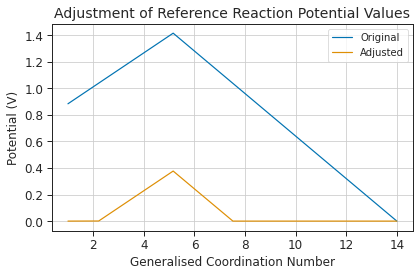

Reaction: PtORR
  Total area under the composite function: 
    Iteration: 1,	Area: 1.053
    Iteration: 2,	Area: 1.000


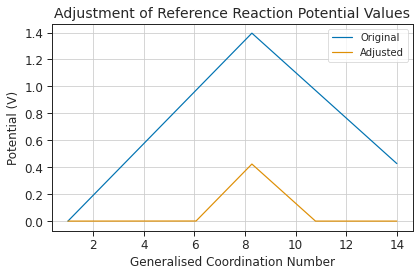

Reaction: PtCOOR
  Total area under the composite function: 
    Iteration: 1,	Area: 1.000


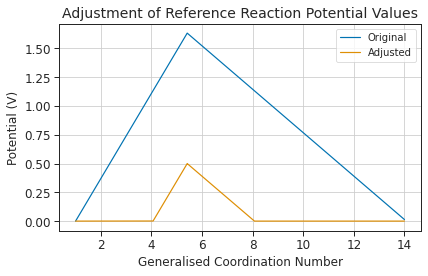

Reaction: CuRWGSR
  Total area under the composite function: 
    Iteration: 1,	Area: 1.016
    Iteration: 2,	Area: 1.000


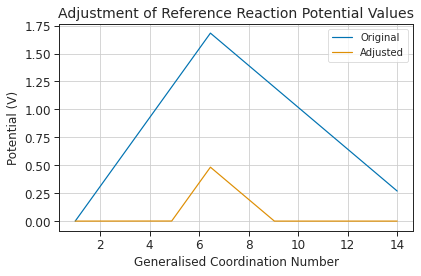

Reaction: CuCO2RR
  Total area under the composite function: 
    Iteration: 1,	Area: 1.909
    Iteration: 2,	Area: 1.039
    Iteration: 3,	Area: 1.000


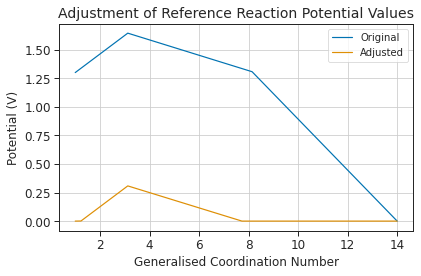

Reaction: PtRCORRR
  Total area under the composite function: 
    Iteration: 1,	Area: 0.759
    Iteration: 2,	Area: 1.005
    Iteration: 3,	Area: 1.000


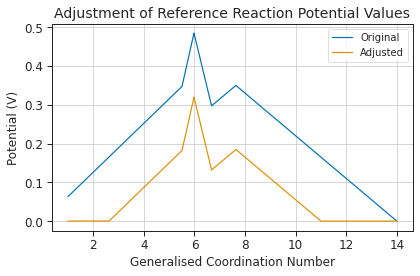

In [27]:
# Global variables that need to be run before gameCase()
# Equations that form the reference GCN-activity plots (Unnormalised)
refReactionsDict = {'AuORR':  # Au NP ORR -- oxygen reduction reaction
                    {'grad': [0.128, -0.16], 'interc': [0.201, 1.686], 'normPotVals': []}, 
                    'PtORR':  # Pt NP ORR
                    {'grad': [0.192, -0.169], 'interc': [-0.715, 2.27], 'normPotVals': []}, 
                    'PtCOOR':  # Pt COOR -- carbon monoxide oxidation reaction
                    {'grad': [0.3701, -0.1886], 'interc': [-2.464, 0.56], 'normPotVals': []}, 
                    'CuRWGSR':  # Cu RWGSR -- reverse water-gas shift reaction ** Units in eV (energy) instead of V (voltage), need further investigation if it were to be included in publication
                    {'grad': [0.30833, -0.1875], 'interc': [-0.88, 2.3225], 'normPotVals': []}, 
                    'CuCO2RR':  # Cu CO2RR -- carbon dioxide reduction reaction
                    {'grad': [0.163, -0.067, -0.223], 'interc': [-1.133, -0.416, 0.853], 'normPotVals': []}, 
                    'PtRCORRR':  # Pt (RCOR)RR -- aliphatic ketone reduction reaction
                    {'grad': [0.063, 0.29, -0.27, 0.055, -0.055], 'interc': [-0.35, -1.60, 1.75, -0.42, 0.42], 'normPotVals': []}} 
evalMetrics = ['Sel', 'Spc', 'Sen']

# Obtain the corresponding potential values for different reference reactions
for reactionName in refReactionsDict.keys():
    if VERBOSE: print(f"Reaction: {reactionName}")
    refReactionsDict[reactionName]['normPotVals'] = potFromGCN(gcns=GCN_XRANGE, 
                                                               gradList=refReactionsDict[reactionName]['grad'], 
                                                               intercList=refReactionsDict[reactionName]['interc'], 
                                                               showImg=SHOW_IMG, 
                                                               verbose=VERBOSE)

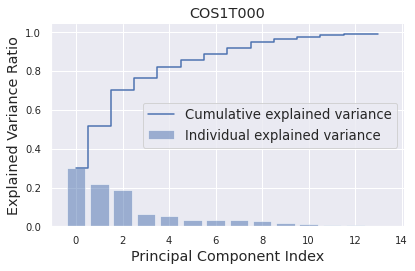

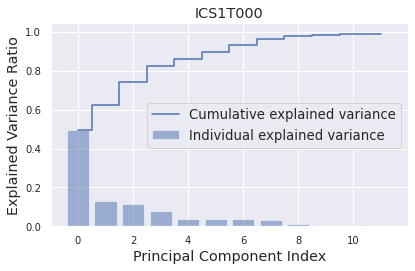

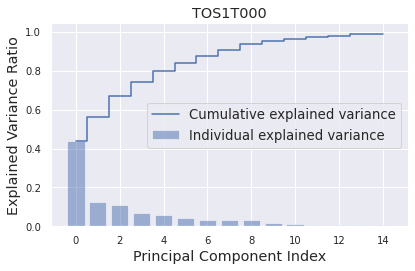

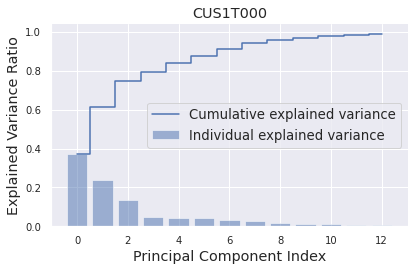

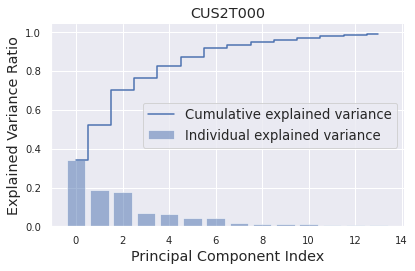

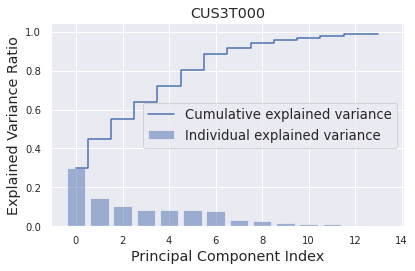

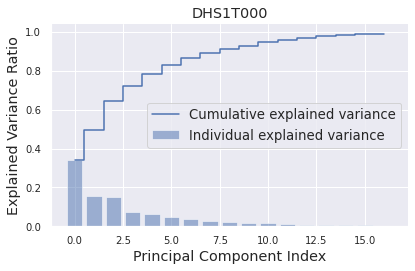

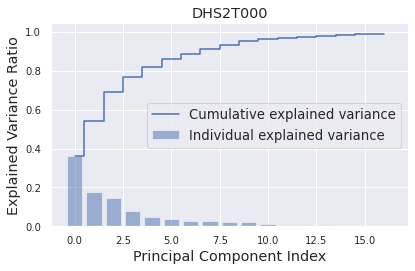

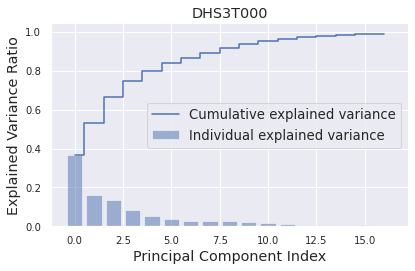

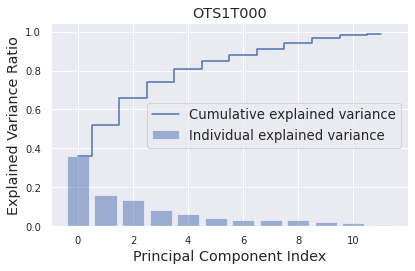

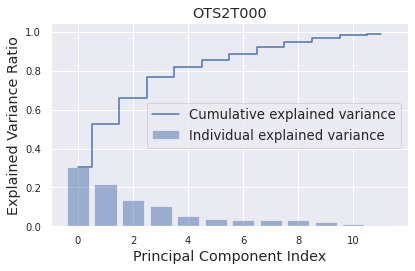

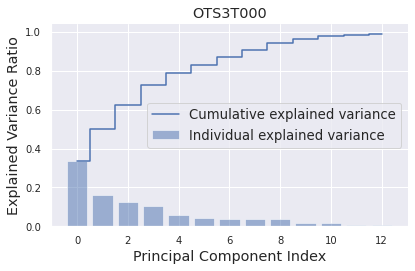

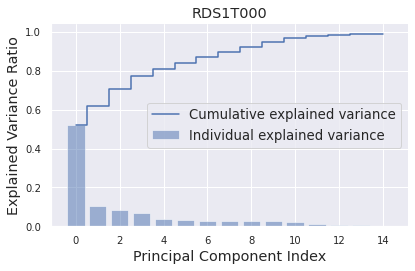

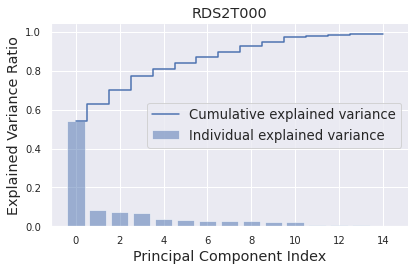

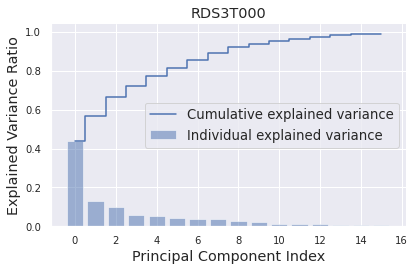

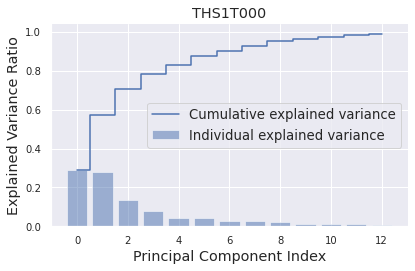

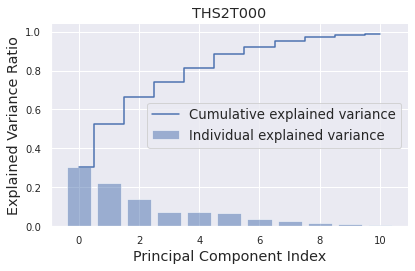

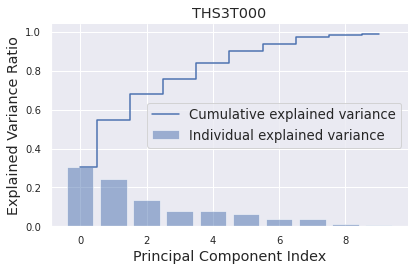

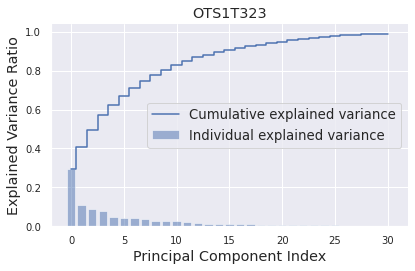

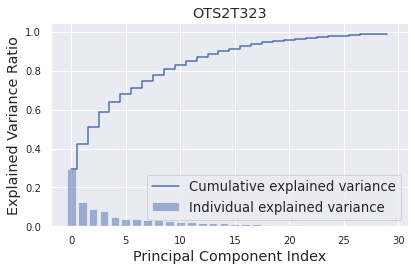

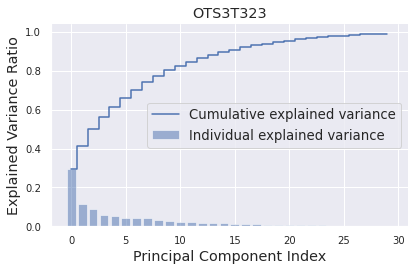

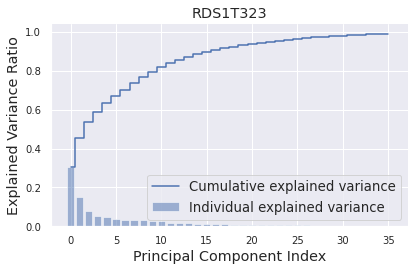

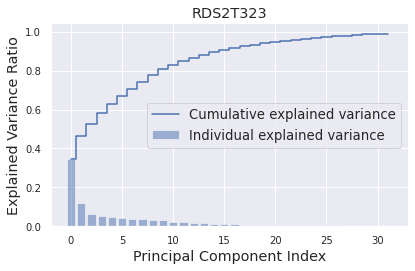

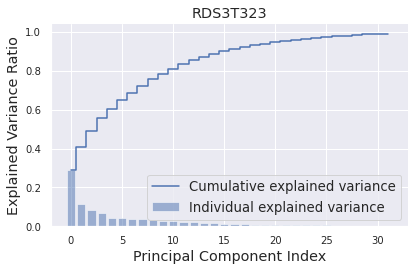

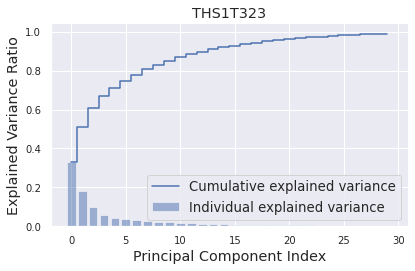

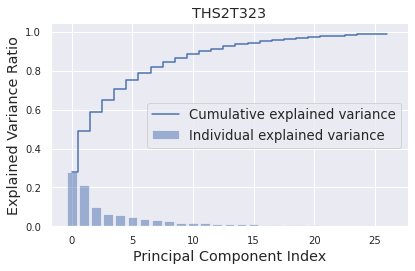

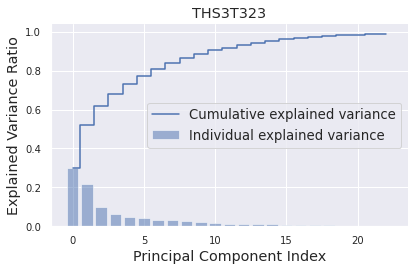

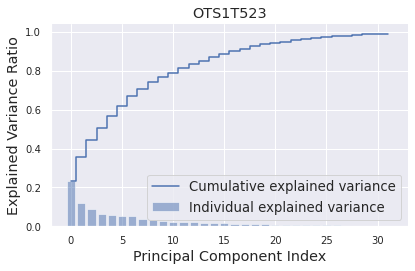

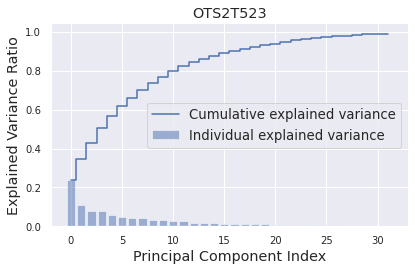

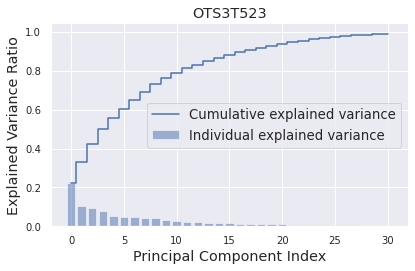

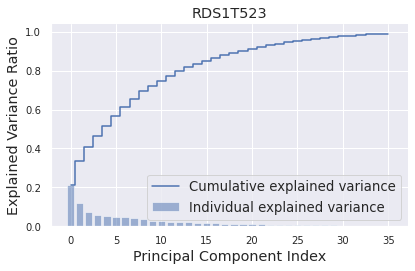

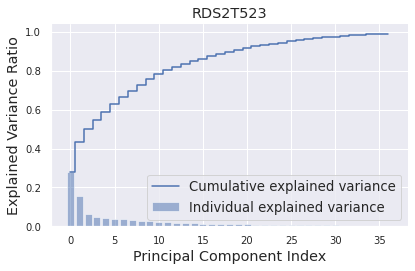

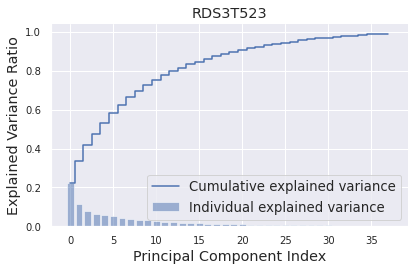

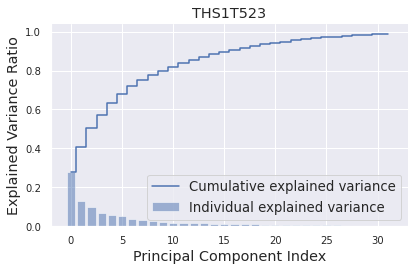

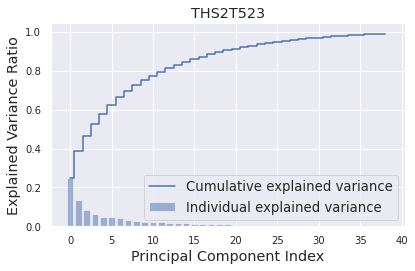

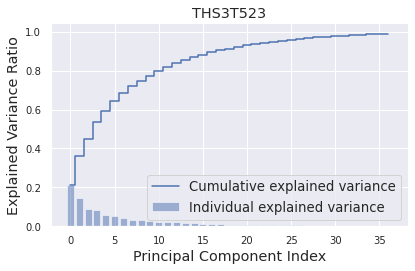

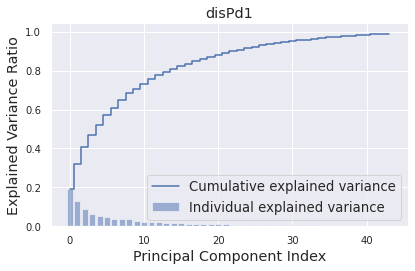

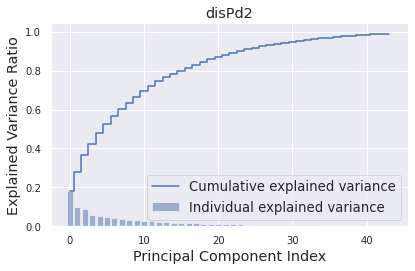

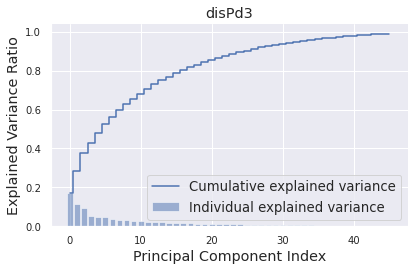

In [23]:
# PCA Exploration
PCA_EXP_VAR_THRESHOLD = 0.99
for (i, dfNoLVHC) in enumerate(dfNoLVHCs):
    df = dfNoLVHC.copy()
    dfScaled = pd.DataFrame(MinMaxScaler().fit_transform(df[df['surf']==1]), columns=df.columns)
    pca = PCA(n_components=PCA_EXP_VAR_THRESHOLD, svd_solver='full').fit(dfScaled)
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance');
    plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance'); 
    plt.ylabel('Explained Variance Ratio');
    plt.xlabel('Principal Component Index'); 
    plt.legend(loc='best');
    plt.title(f"{testCases[i]}");
    plt.tight_layout();
    plt.show();

# Visualise distribution of each feature after scaling 
# (standardisation alters the distribution, normalisation affected by outliers - but don't really have outliers)
# for colName in dfScaled.columns:
#     print(colName)
#     df[df['surf']==1][colName].plot(kind='hist')
#     plt.show()
#     dfScaled[colName].plot(kind='hist')
#     plt.show()

<a id='cluster-vis'></a>
## Cluster Visualisation

In [24]:
def visClust2D(X, y, ILSclust, surfOnly=False, perplexity=30.0, early_exaggeration=12, metric='euclidean', n_neighbors=15, 
               min_dist=0.1, spread=1.0, local_connectivity=1, figSize=(12, 8)):
    """
    Visualise and compare ILS clusters in 2D manifolds.
    
    Parameters:
        X : DataFrame with each column being a feature and each row being an atom instance
        y : Series of true labels corresponding to each sample (not needed if only surface atoms are included)
        ILSclust : List of DataFrames (sorted by index) containing
                    cluster: Float representing ILS cluster labels
                    gamma : Float representing gamma scores of each sample, proportional to the likelihood of the point being a cluster centre
                    gcn : Float representing GCN values of each sample atom
                    AND evaluation metrics regarding cluster GCN distribution toward reference reactions
        surfOnly : Boolean indicating whether only surface atoms are included
        figSize : tuple indicating size of all cluster subplots combined
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, learning_rate=200, n_iter=3000, 
                n_iter_without_progress=300, min_grad_norm=1e-7, metric=metric, random_state=RANDOM_SEED, init='pca', verbose=0, 
                method='barnes_hut', angle=0.5, n_jobs=None)
    umap = UMAP(n_neighbors=n_neighbors, n_components=2, metric=metric, n_epochs=None, learning_rate=1.0, init="spectral", 
                min_dist=min_dist, spread=spread, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=local_connectivity, 
                repulsion_strength=1.0, negative_sample_rate=15, transform_queue_size=4.0, a=None, b=None, random_state=RANDOM_SEED, 
                metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, target_metric="categorical", target_metric_kwds=None, 
                target_weight=0.5, transform_seed=42, verbose=False, unique=False, densmap=False, dens_lambda=2.0, dens_frac=0.3, 
                dens_var_shift=0.1, output_dens=False, disconnection_distance=np.inf)
    redTSNE = tsne.fit_transform(X.drop('label', axis=1))
    redUMAP = umap.fit_transform(X.drop('label', axis=1))
    # fig, axes = plt.subplots(2, 2, figsize=(18, 6));
    plt.figure(figsize=figSize);
    if not surfOnly:
        plt.subplot(221);
    else:
        plt.subplot(121);
    numClusters = len(ILSclust['cluster'].unique())
    scatter1 = plt.scatter(redTSNE[:, 0], redTSNE[:, 1], c=ILSclust['cluster'].sort_index(), cmap=plt.get_cmap('brg', numClusters));
    plt.title("t-SNE Coloured by ILS Clusters");
    plt.legend(handles=scatter1.legend_elements()[0], labels=[i for i in range(numClusters)], title='Cluster');
    if not surfOnly:
        plt.subplot(222);
        plt.scatter(redTSNE[:, 0], redTSNE[:, 1], c=y, cmap=plt.get_cmap('brg', 2));
        plt.title("t-SNE Coloured by Surface");
        plt.legend(handles=scatter1.legend_elements()[0], labels=['Bulk', 'Surface'], title='Surface');
    if not surfOnly:
        plt.subplot(223);
    else:
        plt.subplot(122);
    plt.scatter(redUMAP[:, 0], redUMAP[:, 1], c=ILSclust['cluster'].sort_index(), cmap=plt.get_cmap('brg', numClusters));
    plt.title("UMAP Coloured by ILS Clusters");
    plt.legend(handles=scatter1.legend_elements()[0], labels=[i for i in range(numClusters)], title='Cluster');
    if not surfOnly:
        plt.subplot(224);
        plt.scatter(redUMAP[:, 0], redUMAP[:, 1], c=y, cmap=plt.get_cmap('brg', 2));
        plt.title("UMAP Coloured by Surface");
        plt.legend(handles=scatter1.legend_elements()[0], labels=['Bulk', 'Surface'], title='Surface');
    plt.tight_layout();
    plt.show();

# visClust2D(Xsurf, y_template, ILSclust, surfOnly=True, perplexity=30.0, early_exaggeration=12, metric='euclidean', n_neighbors=15, min_dist=0.1, spread=1.0, local_connectivity=1, figSize=(12, 6))

<a id='cluster-results'></a>
## Clustering Results

<a id='COS1T000'></a>
### Cuboctahedron Small 0K

In [44]:
%%capture PCAcase0
gameCase(caseID=0, verbose=VERBOSE)

In [45]:
%store PCAcase0

Stored 'PCAcase0' (CapturedIO)


<a id='ICS1T000'></a>
### Icosahedron Small 0 K

In [46]:
%%capture PCAcase1
gameCase(caseID=1, verbose=VERBOSE)

In [47]:
%store PCAcase1

Stored 'PCAcase1' (CapturedIO)


<a id='TOS1T000'></a>
### Truncated Octahedron Small 0 K

In [48]:
%%capture PCAcase2
gameCase(caseID=2, verbose=VERBOSE)

In [49]:
%store PCAcase2

Stored 'PCAcase2' (CapturedIO)


<a id='CUS1T000'></a>
### Cube Small 0 K

In [50]:
%%capture PCAcase3
gameCase(caseID=3, verbose=VERBOSE)

In [51]:
%store PCAcase3

Stored 'PCAcase3' (CapturedIO)


<a id='CUS2T000'></a>
### Cube Medium 0 K

In [52]:
%%capture PCAcase4
gameCase(caseID=4, verbose=VERBOSE)

In [53]:
%store PCAcase4

Stored 'PCAcase4' (CapturedIO)


<a id='CUS3T000'></a>
### Cube Large 0 K

In [54]:
%%capture PCAcase5
# case5 to case3 have yet to be run
gameCase(caseID=5, verbose=VERBOSE)

In [55]:
%store PCAcase5

Stored 'PCAcase5' (CapturedIO)


<a id='DHS1T000'></a>
### Decahedron Small 0 K

In [56]:
%%capture PCAcase6
gameCase(caseID=6, verbose=VERBOSE)

In [57]:
%store PCAcase6

Stored 'PCAcase6' (CapturedIO)


<a id='DHS2T000'></a>
### Decahedron Medium 0 K

In [58]:
%%capture PCAcase7
gameCase(caseID=7, verbose=VERBOSE)

In [59]:
%store PCAcase7

Stored 'PCAcase7' (CapturedIO)


<a id='DHS3T000'></a>
### Decahedron Large 0 K

In [60]:
%%capture PCAcase8
gameCase(caseID=8, verbose=VERBOSE)

In [61]:
%store PCAcase8

Stored 'PCAcase8' (CapturedIO)


<a id='OTS1T000'></a>
### Octahedron Small 0 K

In [26]:
%%capture PCAcase9
gameCase(caseID=9, verbose=VERBOSE)

In [27]:
%store PCAcase9

Stored 'PCAcase9' (CapturedIO)


<a id='OTS2T000'></a>
### Octahedron Medium 0 K

In [64]:
%%capture PCAcase10
gameCase(caseID=10, verbose=VERBOSE)

In [65]:
%store PCAcase10

Stored 'PCAcase10' (CapturedIO)


<a id='OTS3T000'></a>
### Octahedron Large 0 K

In [66]:
%%capture PCAcase11
gameCase(caseID=11, verbose=VERBOSE)

In [67]:
%store PCAcase11

Stored 'PCAcase11' (CapturedIO)


<a id='RDS1T000'></a>
### Rhombic Dodecahedron Small 0 K

In [68]:
%%capture PCAcase12
gameCase(caseID=12, verbose=VERBOSE)

In [69]:
%store PCAcase12

Stored 'PCAcase12' (CapturedIO)


<a id='RDS2T000'></a>
### Rhombic Dodecahedron Medium 0 K

In [70]:
%%capture PCAcase13
gameCase(caseID=13, verbose=VERBOSE)

In [71]:
%store PCAcase13

Stored 'PCAcase13' (CapturedIO)


<a id='RDS3T000'></a>
### Rhombic Dodecahedron Large 0 K

In [72]:
%%capture PCAcase14
gameCase(caseID=14, verbose=VERBOSE)

In [73]:
%store PCAcase14

Stored 'PCAcase14' (CapturedIO)


<a id='THS1T000'></a>
### Tetrahedron Small 0 K

In [74]:
%%capture PCAcase15
gameCase(caseID=15, verbose=VERBOSE)

In [75]:
%store PCAcase15

Stored 'PCAcase15' (CapturedIO)


<a id='THS2T000'></a>
### Tetrahedron Medium 0 K

In [76]:
%%capture PCAcase16
gameCase(caseID=16, verbose=VERBOSE)

In [77]:
%store PCAcase16

Stored 'PCAcase16' (CapturedIO)


<a id='THS3T000'></a>
### Tetrahedron Large 0 K

In [78]:
%%capture PCAcase17
gameCase(caseID=17, verbose=VERBOSE)

In [79]:
%store PCAcase17

Stored 'PCAcase17' (CapturedIO)


<a id='OTS1T323'></a>
### Octahedron Small 323 K

In [80]:
%%capture PCAcase18
gameCase(caseID=18, verbose=VERBOSE)

In [81]:
%store PCAcase18

Stored 'PCAcase18' (CapturedIO)


<a id='OTS2T323'></a>
### Octahedron Medium 323 K

In [82]:
%%capture PCAcase19
gameCase(caseID=19, verbose=VERBOSE)

In [83]:
%store PCAcase19

Stored 'PCAcase19' (CapturedIO)


<a id='OTS3T323'></a>
### Octahedron Large 323 K

In [28]:
%%capture PCAcase20
gameCase(caseID=20, verbose=VERBOSE)

In [29]:
%store PCAcase20

Stored 'PCAcase20' (CapturedIO)


<a id='RDS1T323'></a>
### Rhombic Dodecahedron Small 323 K

In [30]:
%%capture PCAcase21
gameCase(caseID=21, verbose=VERBOSE)

In [31]:
%store PCAcase21

Stored 'PCAcase21' (CapturedIO)


<a id='RDS2T323'></a>
### Rhombic Dodecahedron Medium 323 K

In [32]:
%%capture PCAcase22
gameCase(caseID=22, verbose=VERBOSE)

In [33]:
%store PCAcase22

Stored 'PCAcase22' (CapturedIO)


<a id='RDS3T323'></a>
### Rhombic Dodecahedron Large 323 K

In [34]:
%%capture PCAcase23
gameCase(caseID=23, verbose=VERBOSE)

In [35]:
%store PCAcase23

Stored 'PCAcase23' (CapturedIO)


<a id='THS1T323'></a>
### Tetrahedron Small 323 K

In [36]:
%%capture PCAcase24
gameCase(caseID=24, verbose=VERBOSE)

In [37]:
%store PCAcase24

Stored 'PCAcase24' (CapturedIO)


<a id='THS2T323'></a>
### Tetrahedron Medium 323 K

In [38]:
%%capture PCAcase25
gameCase(caseID=25, verbose=VERBOSE)

In [39]:
%store PCAcase25

Stored 'PCAcase25' (CapturedIO)


<a id='THS3T323'></a>
### Tetrahedron Large 323 K

In [40]:
%%capture PCAcase26
gameCase(caseID=26, verbose=VERBOSE)

In [41]:
%store PCAcase26

Stored 'PCAcase26' (CapturedIO)


<a id='OTS1T523'></a>
### Octahedron Small 523 K

In [42]:
%%capture PCAcase27
gameCase(caseID=27, verbose=VERBOSE)

In [43]:
%store PCAcase27

Stored 'PCAcase27' (CapturedIO)


<a id='OTS2T523'></a>
### Octahedron Medium 523 K

In [44]:
%%capture PCAcase28
gameCase(caseID=28, verbose=VERBOSE)

In [45]:
%store PCAcase28

Stored 'PCAcase28' (CapturedIO)


<a id='OTS3T523'></a>
### Octahedron Large 523 K

In [46]:
%%capture PCAcase29
gameCase(caseID=29, verbose=VERBOSE)

In [47]:
%store PCAcase29

Stored 'PCAcase29' (CapturedIO)


<a id='RDS1T523'></a>
### Rhombic Dodecahedron Small 523 K

In [48]:
%%capture PCAcase30
gameCase(caseID=30, verbose=VERBOSE)

In [49]:
%store PCAcase30

Stored 'PCAcase30' (CapturedIO)


<a id='RDS2T523'></a>
### Rhombic Dodecahedron Medium 523 K

In [50]:
%%capture PCAcase31
gameCase(caseID=31, verbose=VERBOSE)

In [51]:
%store PCAcase31

Stored 'PCAcase31' (CapturedIO)


<a id='RDS3T523'></a>
### Rhombic Dodecahedron Large 523 K

In [52]:
%%capture PCAcase32
gameCase(caseID=32, verbose=VERBOSE)

In [53]:
%store PCAcase32

Stored 'PCAcase32' (CapturedIO)


<a id='THS1T523'></a>
### Tetrahedron Small 523 K

In [54]:
%%capture PCAcase33
gameCase(caseID=33, verbose=VERBOSE)

In [55]:
%store PCAcase33

Stored 'PCAcase33' (CapturedIO)


<a id='THS2T523'></a>
### Tetrahedron Medium 523 K

In [56]:
%%capture PCAcase34
gameCase(caseID=34, verbose=VERBOSE)

In [57]:
%store PCAcase34

Stored 'PCAcase34' (CapturedIO)


<a id='THS3T523'></a>
### Tetrahedron Large 523 K

In [58]:
%%capture PCAcase35
gameCase(caseID=35, verbose=VERBOSE)

In [59]:
%store PCAcase35

Stored 'PCAcase35' (CapturedIO)


<a id='disPd1'></a>
### Disordered Pd 1

In [60]:
%%capture PCAcase36
gameCase(caseID=36, verbose=VERBOSE)

In [61]:
%store PCAcase36

Stored 'PCAcase36' (CapturedIO)


<a id='disPd2'></a>
### Disordered Pd 2

In [62]:
%%capture PCAcase37
gameCase(caseID=37, verbose=VERBOSE)

In [63]:
%store PCAcase37

Stored 'PCAcase37' (CapturedIO)


<a id='disPd3'></a>
### Disordered Pd 3

In [64]:
%%capture PCAcase38
gameCase(caseID=38, verbose=VERBOSE)

In [65]:
%store PCAcase38

Stored 'PCAcase38' (CapturedIO)


## Observations regarding Peak Functions Used (for hyperparameter tuning of peak-finding algorithm)
### (caseID, combID) (0, 1), halfwinSize = 20
- S1 fails to pick up 287, 1.2 <= sigConst <= 2.3
- S2 performs well, 0.9 <= sigConst <= 1.5
- S3 either fails to pick up 287 (or picks up 333), 0.8 <= sigConst <= 1.2 (<= 2.1)
### (caseID, combID) (4, 20), halfwinSize = any
- S1 only finds 72, 0.1 <= sigConst <= 1.9
- S2 only finds 72, 0.1 <= sigConst <= 1.9
- S3 only finds 72, 0.1 <= sigConst <= 1.9
### (caseID, combID) (5, 0), halfwinSize = 10
- S1 can find all required peaks, (0.4,) 1.1 <= sigConst <= 2.2
- S2 can find all required peaks, (0.2,) 
** Perhaps shouldn't use mean & std of all positive peak function values, should be looking at mean & std of nearest/previous clusters instead
** Being able to detect peaks that aren't visible to human would be valuable, provided that the peak finding algorithm is validated (on well-defined cases)
** S2 works pretty well generally, but if dominating peaks exist, mean could be large, lots of candidates will be eliminated.
** A point could be dense (depending on cutoff distance) but relatively far from the neighbouring points, causing some ILS plots to start with a peak

In [87]:
%store -r comboResDicts
%store -r PCAcomboResDicts

Stored 'comboResDicts' (list)
Stored 'PCAcomboResDicts' (list)


In [88]:
pd.set_option("max_row", None)

# Combine results into a DataFrame
dfComb, dfCombPCA = pd.DataFrame(), pd.DataFrame()
for (i, comboResDict) in enumerate(comboResDicts):
    df = pd.DataFrame.from_dict(comboResDict, orient="index")
    df["Combination"] = range(len(combList))
    dfComb = pd.concat(objs=[dfComb, df], axis=0, join="outer", ignore_index=False)
for (i, PCAcomboResDict) in enumerate(PCAcomboResDicts):
    df = pd.DataFrame.from_dict(PCAcomboResDict, orient="index")
    df["Combination"] = range(len(combList))
    dfCombPCA = pd.concat(objs=[dfCombPCA, df], axis=0, join="outer", ignore_index=False)
# The next 3 lines should be removed when the cases are rerun
testCaseList = []
for testCase in testCases: testCaseList += [testCase] * len(combList)
dfComb["testCase"], dfCombPCA["testCase"] = testCaseList, testCaseList

multIdx = pd.MultiIndex.from_frame(dfComb.loc[:, ["Combination", "testCase"]])
multIdxPCA = pd.MultiIndex.from_frame(dfCombPCA.loc[:, ["Combination", "testCase"]])
dfComb.index, dfCombPCA.index = multIdx, multIdxPCA
dfComb.drop(labels=["testCase", "Combination"], axis=1, inplace=True)
dfCombPCA.drop(labels=["testCase", "Combination"], axis=1, inplace=True)

In [93]:
dfComb.head()

,,bulkSurf,SHAll,CHAll,DBAll,SHSurface,CHSurface,DBSurface,numClustAll,numClustSurface
Combination,testCase,,,,,,,,,
0,COS1T000,1,0.408300,857.748759,1.067355,0.531779,326.470441,0.746912,6,4
1,COS1T000,1,0.297646,516.041330,1.644453,0.420228,229.203524,1.023699,6,4
2,COS1T000,1,0.387044,724.917500,1.130309,0.445693,264.078726,0.901544,6,4
3,COS1T000,1,0.400250,692.897299,1.096448,0.501126,271.393904,0.805916,6,4
4,COS1T000,1,0.315037,818.619277,1.445802,0.498279,303.139694,0.896956,5,3


In [94]:
dfCombPCA.head()

,,bulkSurf,SHAll,CHAll,DBAll,SHSurface,CHSurface,DBSurface,numClustAll,numClustSurface
Combination,testCase,,,,,,,,,
0,COS1T000,1,0.419752,891.807000,1.051190,0.534893,331.265802,0.742405,6,4
1,COS1T000,1,0.306512,532.771728,1.641376,0.421832,230.824009,1.020698,6,4
2,COS1T000,1,0.393489,745.117931,1.124086,0.448645,267.520836,0.895787,6,4
3,COS1T000,1,0.399767,700.255041,1.110304,0.503968,274.972856,0.801577,6,4
4,COS1T000,1,0.320923,845.026855,1.429279,0.511845,311.235697,0.823755,5,4


In [ ]:
# Add domain knowledge related features to the DataFrame
allFeat = [tuple(q0List), tuple(posList), tuple(radList), tuple(geomList), tuple(neighList), tuple(orderList)]
allFeatNames = ["q0List", "posList", "radList", "geomList", "neighList", "orderList"]
domainDict = {i: {"q0List": 0, "posList": 0, "radList": 0, "geomList": 0, "neighList": 0, "orderList": 0} for i in range(len(combList))}
for (i, comb) in enumerate(combList):
    for (j, feats) in enumerate(allFeat):
        if feats[0] in comb: domainDict[i][allFeatNames[j]] = 1
dfCombDomainSingle = pd.DataFrame.from_dict(domainDict, orient="index")
dfCombDomain = dfCombDomainSingle.copy()
for i in range(len(testCases)): dfCombDomain = dfCombDomain.append(dfCombDomainSingle, ignore_index=False)
dfCombDomain.index = dfComb.index
dfComb[allFeatNames] = dfCombDomain

# Extract Cartesian coordinates and ILS clusters for each nanoparticle
headerList = ["x", "y", "z"]
for i in range(63): headerList.append(f"allClust{i}")
for i in range(63): headerList.append(f"surfClust{i}")
xyzClustList = []
for caseID in range(len(testCases)):
    xyzClustFile = f"figures/ILSclust/{testCases[caseID]}_ILS.xyz"
    xyzClustList.append(pd.read_csv(xyzClustFile, sep=" ", skiprows=2, usecols=[1, 2, 3] + list(range(58, 184)), names=headerList))
    
# Filter combinations by average centroid of each cluster from its distribution and correlations between Cartesian coordinates and cluster distribution
verbose = True
dfComb["acentAll"], dfComb["acentSurf"] = None, None
dfComb["corrXall"], dfComb["corrYall"], dfComb["corrZall"] = None, None, None
dfComb["corrXsurf"], dfComb["corrYsurf"], dfComb["corrZsurf"] = None, None, None
centThresh, corrThresh = 0.05, 0.8
for (i, testCase) in enumerate(testCases):
    if verbose: 
        print(f"\nTest case: {i}, {testCase}")
    dfXYZclust = xyzClustList[i]
    dfXYZclust["x"] = (dfXYZclust["x"]-dfXYZclust["x"].min()) / (dfXYZclust["x"].max()-dfXYZclust["x"].min())
    dfXYZclust["y"] = (dfXYZclust["y"]-dfXYZclust["y"].min()) / (dfXYZclust["y"].max()-dfXYZclust["y"].min())
    dfXYZclust["z"] = (dfXYZclust["z"]-dfXYZclust["z"].min()) / (dfXYZclust["z"].max()-dfXYZclust["z"].min())
    for j in range(len(combList)):
        clustAllList, clustSurfList = dfXYZclust[f"allClust{j}"].unique(), dfXYZclust[f"surfClust{j}"].unique()
        if verbose: print(f"  Combination {j} -- {len(clustAllList)} clusters in total, {len(clustSurfList)} surface clusters")
        
        # Correlations
        corrXall, corrXsurf = dfXYZclust["x"].corr(dfXYZclust[f"allClust{j}"]), dfXYZclust["x"].corr(dfXYZclust[f"surfClust{j}"])
        corrYall, corrYsurf = dfXYZclust["y"].corr(dfXYZclust[f"allClust{j}"]), dfXYZclust["y"].corr(dfXYZclust[f"surfClust{j}"])
        corrZall, corrZsurf = dfXYZclust["z"].corr(dfXYZclust[f"allClust{j}"]), dfXYZclust["z"].corr(dfXYZclust[f"surfClust{j}"])
        if verbose: 
            print(f"  Correlations of x, y, z with ILS all clusters: {corrXall:.2f} {corrYall:.2f} {corrZall:.2f}")
            print(f"  Correlations of x, y, z with ILS surface clusters: {corrXsurf:.2f} {corrYsurf:.2f} {corrZsurf:.2f}")
        dfComb["corrXall"].loc[j, testCase], dfComb["corrYall"].loc[j, testCase], dfComb["corrZall"].loc[j, testCase] = corrXall, corrYall, corrZall
        dfComb["corrXsurf"].loc[j, testCase], dfComb["corrYsurf"].loc[j, testCase], dfComb["corrZsurf"].loc[j, testCase] = corrXsurf, corrYsurf, corrZsurf
        corrList = [corrXall, corrYall, corrZall, corrXsurf, corrYsurf, corrZsurf]
        if any(abs(corr) > corrThresh for corr in corrList):
            if verbose: print(f"    Correlation greater than {corrThresh}!")

        acentAll, acentSurf = 0, 0
        for clust in clustAllList:
            if verbose: print(f"    Cluster: {clust}")
            dfClust = dfXYZclust[dfXYZclust[f"allClust{j}"] == clust]
            for axis in ("x", "y", "z"):
                if dfClust[axis].mean() > 0.5 + centThresh or dfClust[axis].mean() < 0.5 - centThresh: 
                    if verbose: print(f"      Cluster centroid in {axis} direction not centred!")
                    acentAll += 1
                    break
        for clust in clustSurfList:
            if verbose: print(f"    Surface Cluster: {clust}")
            dfClust = dfXYZclust[dfXYZclust[f"surfClust{j}"] == clust]
            for axis in ("x", "y", "z"):
                if dfClust[axis].mean() > 0.5 + centThresh or dfClust[axis].mean() < 0.5 - centThresh: 
                    if verbose: print(f"      Cluster centroid in {axis} direction not centred!")
                    acentSurf += 1
                    break
        dfComb["acentAll"].loc[j, testCase], dfComb["acentSurf"].loc[j, testCase] = acentAll, acentSurf
dfComb = dfComb.astype({"acentAll": "int64", "acentSurf": "int64", 
                        "corrXall": "float64", "corrYall": "float64", "corrZall": "float64", 
                        "corrXsurf": "float64", "corrYsurf": "float64", "corrZsurf": "float64"}, errors="raise")
%store dfComb